# **🧰 1. Import Required Libraries**

Import all necessary libraries

In [84]:
import requests
import csv
import pandas as pd
import glob
import os
import numpy as np
import ast
import time
import libtorrent as lt
import zstandard as zstd
import io
import json
import re
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
import random
import math
import xgboost as xgb
from transformers import BertTokenizer, BertForSequenceClassification, pipeline, AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax
from sklearn.preprocessing import StandardScaler
from hmmlearn.hmm import GaussianHMM
from itertools import combinations, product
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_regression
from tqdm import tqdm
from collections import deque
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam


# **🌐 2. Define API URLs**

URL of the API endpoint to fetch targeted market data

In [3]:
# Exchange Inflow
url1 = "https://api.datasource.cybotrade.rs/cryptoquant/btc/exchange-flows/inflow?exchange=binance&window=hour&limit=45000&start_time=1585670400000"
# Exchange Outflow
url2 = "https://api.datasource.cybotrade.rs/cryptoquant/btc/exchange-flows/outflow?exchange=binance&window=hour&limit=45000&start_time=1585670400000"
# Active address
url3 = "https://api.datasource.cybotrade.rs/glassnode/addresses/accumulation_count?a=BTC&c=native&i=24h&start_time=1585670400000&limit=45000"
# Coin days destroyed (CDD)
url4 = "https://api.datasource.cybotrade.rs/glassnode/indicators/cdd?a=BTC&c=native&i=1h&start_time=1585670400000&limit=45000"
# Fear Greed Index
url5 = "https://api.datasource.cybotrade.rs/glassnode/indicators/fear_greed?a=BTC&c=native&i=24h&start_time=1585670400000&limit=45000"
# MVRV
url6 = "https://api.datasource.cybotrade.rs/glassnode/indicators/mvrv_account_based?a=BTC&c=native&i=1h&start_time=1585670400000&limit=45000"
# SOPR
url7 = "https://api.datasource.cybotrade.rs/glassnode/indicators/sopr_adjusted?a=BTC&c=native&i=1h&start_time=1585670400000&limit=45000"
# Market Price
url8 = "https://api.datasource.cybotrade.rs/glassnode/market/price_usd_ohlc?a=BTC&c=native&i=1h&start_time=1585670400000&limit=45000"
# Volume
url9 = "https://api.datasource.cybotrade.rs/glassnode/transactions/transfers_volume_sum?a=BTC&c=native&i=24h&start_time=1585670400000&limit=45000"


Fetch market data from the API endpoints


In [4]:
api_key = 'Your API Key'

headers = {
    'X-API-KEY': api_key,
}
urls = [
    ("exchange_inflow", url1),
    ("exchange_outflow", url2),
    ("active_address", url3),
    ("cdd", url4),
    ("fear_greed", url5),
    ("mvrv", url6),
    ("sopr", url7),
    ("market_price", url8),
    ("volume", url9),
]

for name, url in urls:
    response = requests.get(url, headers=headers)

    if response.status_code == 200:
        data = response.json()

        if isinstance(data, dict) and "data" in data:
            data_list = data["data"]

            if data_list:
                filename = f"{name}.csv"
                with open(filename, mode='w', newline='', encoding='utf-8') as file:
                    writer = csv.writer(file)
                    header = data_list[0].keys()
                    writer.writerow(header)
                    for row in data_list:
                        writer.writerow(row.values())
                print(f"{name} data saved to {filename}")
            else:
                print(f"No data in 'data' field for {name}")
        else:
            print(f"Unexpected structure for {name}")
    else:
        print(f"Failed to fetch {name}, Status Code: {response.status_code}")


exchange_inflow data saved to exchange_inflow.csv
exchange_outflow data saved to exchange_outflow.csv
active_address data saved to active_address.csv
cdd data saved to cdd.csv
fear_greed data saved to fear_greed.csv
mvrv data saved to mvrv.csv
sopr data saved to sopr.csv
market_price data saved to market_price.csv
volume data saved to volume.csv


Combine all fetched data into a CSV file

In [5]:
# Format: "filename": ("original_column_name", "new_column_name")
value_columns = {
    "exchange_inflow": ("inflow_mean_ma7", "inflow_mean_ma7"),
    "exchange_outflow": ("outflow_mean_ma7", "outflow_mean_ma7"),
    "active_address": ("v", "activeAdd"),
    "cdd": ("v", "cdd"),
    "fear_greed": ("v", "fearGreed"),
    "mvrv": ("v", "mvrv"),
    "sopr": ("v", "sopr"),
    "market_price": ("o", "prices"),
    "volume": ("v", "volume")
}


# === File processing ===
csv_files = glob.glob("/content/*.csv")
dfs = []

for file in csv_files:
    try:
        source_name = os.path.splitext(os.path.basename(file))[0]

        if source_name in value_columns:
            original_col, new_col = value_columns[source_name]
            df = pd.read_csv(file)

            # Keep only 'start_time' and the target value column
            df = df[['start_time', original_col]]
            df = df.rename(columns={original_col: new_col})
            dfs.append(df)
        else:
            print(f"Skipping {file} - no mapping found in value_columns")

    except Exception as e:
        print(f"Failed to process {file}: {e}")

# === Merge all dataframes on 'start_time' ===
if dfs:
    merged_df = dfs[0]
    for df in dfs[1:]:
        merged_df = pd.merge(merged_df, df, on='start_time', how='outer')
    merged_df = merged_df.rename(columns={"start_time": "timestamp"})
    merged_df.to_csv("combined_dataset.csv", index=False)
    print("Combined dataset saved as combined_dataset.csv")
else:
    print("No valid CSVs found to combine.")

print(merged_df.head(10))


Combined dataset saved as combined_dataset.csv
       timestamp            cdd      sopr  outflow_mean_ma7  fearGreed  \
0  1585670400000  129157.855632  1.000732         45.395236        NaN   
1  1585674000000  144309.178065  0.997346         46.224050        NaN   
2  1585677600000  206949.292388  0.988512         42.747536        NaN   
3  1585681200000  234399.902759  0.961111         55.875381        NaN   
4  1585684800000   46045.393106  0.991515         34.896499        NaN   
5  1585688400000   95327.422205  0.988861         32.499516        NaN   
6  1585692000000  161968.572222  0.995343         28.390809        NaN   
7  1585695600000  237337.298541  0.995803         30.532525        NaN   
8  1585699200000   46130.797591  0.985079         30.247587       12.0   
9  1585702800000   66139.315438  0.973512         32.129572        NaN   

   inflow_mean_ma7                                             prices  \
0         0.901738  {'c': 6466.12815156, 'h': 6485.22037975, 'l':

# **📦Data Preprocessing**

Data preprocessing for combined fetched data




In [6]:
# Load dataset
df = pd.read_csv('combined_dataset.csv')

# Check for missing values
print("Missing values in each column:")
missing_values = df.isna().sum()
print(missing_values)

Missing values in each column:
timestamp               0
cdd                     0
sopr                  136
outflow_mean_ma7        0
fearGreed           42441
inflow_mean_ma7         0
prices                  0
mvrv                    0
volume              42441
activeAdd           42441
dtype: int64


In [7]:
df['sopr'] = df['sopr'].fillna(df['sopr'].mean())
 # Fill using the last valid value for each day
df['fearGreed'] = df['fearGreed'].fillna(method='ffill')
df['prices'] = df['prices'].fillna(method='ffill')
df['volume'] = df['volume'].fillna(method='ffill')
df['activeAdd'] = df['activeAdd'].fillna(method='ffill')

# Drop rows with empty values
df = df.dropna()

<ipython-input-7-a58546708a2f>:3: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['fearGreed'] = df['fearGreed'].fillna(method='ffill')
<ipython-input-7-a58546708a2f>:4: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['prices'] = df['prices'].fillna(method='ffill')
<ipython-input-7-a58546708a2f>:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['volume'] = df['volume'].fillna(method='ffill')
<ipython-input-7-a58546708a2f>:6: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['activeAdd'] = df['activeAdd'].fillna(method='ffill')


In [8]:
# Check for missing values
print("Missing values in each column:")
missing_values = df.isna().sum()
print(missing_values)

Missing values in each column:
timestamp           0
cdd                 0
sopr                0
outflow_mean_ma7    0
fearGreed           0
inflow_mean_ma7     0
prices              0
mvrv                0
volume              0
activeAdd           0
dtype: int64


In [9]:
df.to_csv('pretty_dataset.csv',index=False)

# **⚙️Feature Engineering**

In [10]:
# Load dataset
df = pd.read_csv("/content/pretty_dataset.csv")

# Extract 'c' from 'price'
df['price'] = df['prices'].apply(lambda x: ast.literal_eval(x)['c'])
df.drop(columns=['prices'], inplace=True)

# Netflow
df['netflow'] = df['inflow_mean_ma7'] - df['outflow_mean_ma7']
df.drop(columns=['inflow_mean_ma7', 'outflow_mean_ma7'], inplace=True)

# RSI (14-period)
delta = df['price'].diff()
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
avg_gain = gain.rolling(window=14).mean()
avg_loss = loss.rolling(window=14).mean()
rs = avg_gain / avg_loss
df['RSI'] = 100 - (100 / (1 + rs))

# Volatility (20-period standard deviation of returns)
df['returns'] = df['price'].pct_change()
df['volatility'] = df['returns'].rolling(window=20).std()
df.drop(columns=['returns'], inplace=True)

# Drop rows with NaN values from rolling calculations
df = df.dropna()

In [11]:
# Convert start_time to datetime (but keep original ms separately)
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
df.set_index('timestamp', inplace=True)

# Resample to 4-hour intervals
df_4h = df.resample('4H').agg({
    'activeAdd': 'last',
    'cdd': 'sum',
    'fearGreed': 'last',
    'mvrv': 'mean',
    'sopr': 'mean',
    'volume': 'sum',
    'price': 'last',
    'netflow': 'mean',
    'RSI': 'mean',
    'volatility': 'mean'
})

# Convert the datetime index back to milliseconds
df_4h['timestamp'] = df_4h.index.astype('int64') // 10**6  # nanoseconds to milliseconds

# Reorder columns if needed
df_4h = df_4h.reset_index(drop=True)[['timestamp'] + [col for col in df_4h.columns if col != 'timestamp']]

df_4h['price_changes'] = df_4h['price'].pct_change() * 100
df_4h['log_return'] = np.log(df_4h['price'] / df_4h['price'].shift(1))

df_4h = df_4h.dropna()

# Train test split
df_4h['timestamp'] = pd.to_numeric(df_4h['timestamp'])
df_train = df_4h[df_4h["timestamp"] < 1640995200000]
df_btest = df_4h[(df_4h["timestamp"] >= 1640995200000) & (df_4h["timestamp"] < 1704067200000)]
df_ftest = df_4h[df_4h["timestamp"] >= 1704067200000]

df_train.to_csv("featured_train.csv", index=False)
df_btest.to_csv("featured_btest.csv", index=False)
df_ftest.to_csv("featured_ftest.csv", index=False)

<ipython-input-11-de02cc40bce5>:6: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_4h = df.resample('4H').agg({


# **Natural Language Processing (NLP)**

Download Reddit posts data using BitTorrent protocol.

In [ ]:
# Create a torrent session
ses = lt.session()

# Set download parameters
params = {
    "save_path": "/content/",  # Save to Colab VM’s disk
    "storage_mode": lt.storage_mode_t.storage_mode_sparse  # Sparse mode for efficiency
}

# Add the torrent using your magnet link
handle = ses.add_torrent({
    "url": "magnet:?xt=urn:btih:43a6e113d6ecacf38e58ecc6caa28d68892dd8af&tr=https%3A%2F%2Facademictorrents.com%2Fannounce.php&tr=udp%3A%2F%2Ftracker.coppersurfer.tk%3A6969&tr=udp%3A%2F%2Ftracker.opentrackr.org%3A1337%2Fannounce",
    **params
})

print("Starting download...")
while not handle.is_seed():
    s = handle.status()
    print(f"Progress: {s.progress * 100:.2f}% | Speed: {s.download_rate / 1024:.2f} KB/s")
    time.sleep(5)
print("Download complete!")

Extract posts, upvotes, comments, and all relevant information from downloaded data for each month. Due to data size limitations (5 years of data could reach terabytes), we limited the extraction to three months: December 2024 to February 2025.

In [ ]:
filename = "/content/reddit/submissions/RS_2024-09.zst"
output_csv = "/content/batch_filtered_reddit_2024-09.csv"

# Subreddits of interest
target_subreddits = {'bitcoin', 'cryptocurrency', 'bitcoinmarkets', 'cryptomarkets'}

# Filtering thresholds
min_score = 10
min_upvote_ratio = 0.7
min_comments = 3

# Prepare a list to collect data
filtered_posts = []

# Batch size (how many posts to process before saving)
batch_size = 10

with open(filename, 'rb') as compressed:
    dctx = zstd.ZstdDecompressor()
    with dctx.stream_reader(compressed) as reader:
        text_stream = io.TextIOWrapper(reader, encoding='utf-8')

        for i, line in enumerate(text_stream):
            try:
                post = json.loads(line)

                subreddit = post.get("subreddit", "").lower()
                if subreddit in target_subreddits:

                    post_url = post.get("url", "")
                    if not post_url.startswith(("https://www.reddit.com",
                                                "https://old.reddit.com",
                                                "https://new.reddit.com")):
                        continue  # Skip non-Reddit URLs

                    if post_url.lower().endswith(('.jpg', '.jpeg')):
                        continue  # Skip JPEG URLs

                    # Apply thresholds
                    if post.get("score", 0) < min_score:
                        continue
                    if post.get("upvote_ratio", 0) < min_upvote_ratio:
                        continue
                    if post.get("num_comments", 0) < min_comments:
                        continue

                    filtered_posts.append({
                        "timestamp": post.get("created_utc"),
                        "subreddit": subreddit,
                        "title": post.get("title", ""),
                        "text": post.get("selftext", ""),
                        "score": post.get("score", 0),
                        "ups": post.get("ups", 0),
                        "downs": post.get("downs", 0),
                        "num_comments": post.get("num_comments", 0),
                        "urls": post.get("url", ""),
                        "upvote_ratio": post.get("upvote_ratio", 0),
                    })

            except json.JSONDecodeError:
                continue  # skip bad lines

            # Write in batches
            if len(filtered_posts) >= batch_size:
                df = pd.DataFrame(filtered_posts)
                df.to_csv(output_csv, mode='a', header=not bool(i), index=False)
                filtered_posts.clear()
                print("added")

        # Save any remaining posts
        if filtered_posts:
            df = pd.DataFrame(filtered_posts)
            df.to_csv(output_csv, mode='a', header=not bool(i), index=False)

print(f"Finished processing. Filtered posts saved to {output_csv}")


Buzz Factor and FinBERT Model - To obtain sentiment scores and calculate the buzz factor of Reddit posts.

In [ ]:
# Load the Reddit data
df = pd.read_csv('reddit_2025-02.csv')

# Convert Unix timestamp to a readable date format
df['date'] = pd.to_datetime(df['timestamp'], unit='s').dt.date

# Create a quick engagement score based on upvotes and comments
df['engagement_score'] = (df['ups'] * df['upvote_ratio']) + df['num_comments']

# Load FinBERT model and tokenizer for financial sentiment analysis
tokenizer = AutoTokenizer.from_pretrained("yiyanghkust/finbert-tone")
model = AutoModelForSequenceClassification.from_pretrained("yiyanghkust/finbert-tone")

# Function to calculate sentiment score from post title + body
def get_sentiment_score(title, text):
    title = str(title) if isinstance(title, str) else ""
    text = str(text) if isinstance(text, str) else ""
    full_text = title + " " + text
    try:
        inputs = tokenizer(full_text, return_tensors="pt", truncation=True, padding=True, max_length=512)
        with torch.no_grad():
            logits = model(**inputs).logits
        probs = softmax(logits[0].numpy())
        return float(probs[2] - probs[0])  # Positive - Negative
    except Exception as e:
        print(f"Couldn't process: {title[:30]}... => {e}")
        return 0.0

# Apply the sentiment scoring function to each Reddit post
df['sentiment_score'] = df.apply(lambda row: get_sentiment_score(row['title'], row['text']), axis=1)

# Normalize engagement (buzz) and sentiment scores using Z-score
scaler = StandardScaler()
df[['buzz_factor']] = scaler.fit_transform(df[['engagement_score']])
df[['sentiment_z']] = scaler.fit_transform(df[['sentiment_score']])

# Combine sentiment and buzz into one smart score
def compute_combined(row):
    buzz = row['buzz_factor']
    sentiment = row['sentiment_z']
    return sentiment - (buzz * (1 - sentiment))  # Penalize high buzz with weak sentiment

df['combined_raw'] = df.apply(compute_combined, axis=1)

# Normalize the combined score too
df['combined_zscore'] = scaler.fit_transform(df[['combined_raw']])

# Clean up the temp column
df.drop(columns=['combined_raw'], inplace=True)

# Save the final output
df.to_csv('reddit_2025-02__combined.csv', index=False)
print("All done! Final file saved as 'reddit_2025-02__combined.csv'")


Scrape news from CoinDesk's HTML. The free version of the CryptoPanic API provides access to only 200 news articles (about one month's worth of data), limiting the amount of information I can gather. Scraping news from CoinDesk would help overcome this limitation and provide more comprehensive data for better model results.

In [ ]:
import time
import selenium
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from bs4 import BeautifulSoup
import pandas as pd
from datetime import datetime, timedelta
import re

# Function to convert relative time strings (e.g., "5 minutes ago") into actual datetime objects
def parse_relative_time(text):
    text = text.lower()  # Convert text to lowercase for easier matching
    now = datetime.now()  # Get current time

    # Regular expression to match time strings like "5 minutes ago"
    match = re.match(r"(\d+)\s+(minute|hour|day|second)s?\s+ago", text)
    if match:
        value, unit = int(match.group(1)), match.group(2)
        if unit == "minute":
            return now - timedelta(minutes=value)
        elif unit == "hour":
            return now - timedelta(hours=value)
        elif unit == "day":
            return now - timedelta(days=value)
        elif unit == "second":
            return now - timedelta(seconds=value)
    elif text == "just now":
        return now  # If the time is "just now", return current time
    else:
        return None

# Function to parse date strings in the format "Month day, year"
def parse_date(date_str):
    try:
        return datetime.strptime(date_str, "%b %d, %Y")  # Parse into datetime object
    except ValueError:
        return None  # If it can't be parsed, return None

# Function to save the scraped data grouped by month
def save_data_by_month(data):
    data['published_time'] = pd.to_datetime(data['published_time'])  # Convert to datetime
    grouped = data.groupby([data['published_time'].dt.year, data['published_time'].dt.month])  # Group by year and month

    # Save each group to a separate CSV file
    for (year, month), group in grouped:
        file_name = f'coindesk_headlines_{year}_{month:02}.csv'  # Generate file name
        group.to_csv(file_name, index=False)  # Save group to CSV
        print(f"Data saved to {file_name}")

# Main scraping function to get news from CoinDesk
def scrape_coindesk_all_h2():
    url = "https://www.coindesk.com/latest-crypto-news"  # URL to scrape CoinDesk's latest crypto news

    # Set up Chrome options to run in headless mode (without opening a browser window)
    options = Options()
    options.add_argument('--headless')
    options.add_argument('--disable-gpu')
    options.add_argument('--no-sandbox')
    options.add_argument('--window-size=1920,1080')
    options.add_argument('--lang=en-US')

    # Initialize Chrome WebDriver
    service = Service()
    driver = webdriver.Chrome(service=service, options=options)
    wait = WebDriverWait(driver, 10)  # Wait time for elements to load

    try:
        driver.get(url)  # Navigate to CoinDesk's news page
        time.sleep(3)  # Wait for the page to load

        all_data = []  # List to store scraped news data
        previous_headlines = set()  # Set to avoid duplicate headlines
        stop_date = datetime(2021, 12, 31)  # Stop scraping if we find news before this date
        clicks = 0  # Counter for tracking page clicks

        while True:
            try:
                soup = BeautifulSoup(driver.page_source, 'html.parser')  # Parse the HTML of the page
                h2_tags = soup.find_all('h2', class_='font-headline-xs font-normal')  # Find all h2 tags (headlines)
                span_tags = soup.find_all('span', class_='font-metadata text-color-charcoal-600 uppercase')  # Find all span tags (dates)

                # Extract headline texts
                headlines = [h2.get_text(strip=True) for h2 in h2_tags if h2.get_text(strip=True)]
                # Extract the date texts
                dateList = [span.get_text(strip=True) for span in span_tags if span.get_text(strip=True)]

                # Parse the dates
                published_times = []
                for date_str in dateList:
                    relative_time = parse_relative_time(date_str)  # Try to parse relative time (e.g., "5 minutes ago")
                    if relative_time:
                        published_times.append(relative_time)
                    else:
                        parsed_date = parse_date(date_str)  # Try to parse fixed date (e.g., "Dec 31, 2021")
                        published_times.append(parsed_date if parsed_date else None)

                # Print progress and parse the headlines and times
                print(f"\nPage {clicks + 1} scraped data:")
                for i, published_time in enumerate(published_times):
                    if not published_time:  # Skip if no valid time was parsed
                        continue

                    if published_time < stop_date:  # Stop if the news is older than the stop date
                        print(f" Found date earlier than {stop_date.strftime('%b %d, %Y')}: {published_time}")
                        raise StopIteration  # Stop scraping

                    headline = headlines[i]
                    if headline in previous_headlines:  # Skip if the headline is a duplicate
                        continue

                    previous_headlines.add(headline)  # Add the new headline to the set

                    # Save the news data
                    print(f"{published_time} - {headline}")
                    all_data.append({
                        'timestamp': dateList[i],
                        'published_time': published_time,
                        'headline': headline,
                        'source': 'CoinDesk'
                    })

                # Click "More stories" to load more news articles
                more_btn = wait.until(EC.element_to_be_clickable((By.XPATH, '//button[normalize-space()="More stories"]')))
                driver.execute_script("arguments[0].click();", more_btn)
                print(f"Clicked 'More stories' button, iteration {clicks + 1}")
                clicks += 1
                time.sleep(3)  # Wait for the next set of news to load

            except StopIteration:  # If we hit the stop condition, break out of the loop
                break
            except Exception as e:
                print("Error occurred or no more 'More stories' button:", e)  # Handle any exceptions
                break

        # Save the data if we have scraped any valid news
        if all_data:
            df = pd.DataFrame(all_data)  # Convert the list of data into a pandas DataFrame
            df = df.drop_duplicates(subset='headline')  # Remove duplicate headlines
            df['published_time'] = df['published_time'].dt.strftime('%Y-%m-%d %H:%M:%S')  # Format the published time
            df.to_csv("coindesk_headlines_all.csv", index=False, encoding='utf-8')  # Save the data to a CSV file
            print(f"\nFinal data saved to 'coindesk_headlines_all.csv' ({len(df)} records).")
            return df  # Return the scraped data as a DataFrame
        else:
            print("No valid headlines to save.")  # If no valid headlines were found
            return pd.DataFrame()

    except Exception as e:
        print(f"Error occurred: {str(e)}")  # Handle any errors
        return pd.DataFrame()  # Return an empty DataFrame if an error occurs
    finally:
        driver.quit()  # Ensure the WebDriver is closed when done

# Main script execution
if __name__ == "__main__":
    news_data = scrape_coindesk_all_h2()  # Start the scraping process
    if not news_data.empty:
        print(f"Scraped {len(news_data)} headlines.")
    else:
        print("No headlines found.")  # If no headlines were found, print a warning


Buzz Factor and FinBERT Model - To obtain sentiment scores and calculate the buzz factor of CoinDesk news.

In [ ]:
# Load the Coindesk headlines dataset
df = pd.read_csv('coindesk_headlines_all (8).csv')

# Clean up the date column and convert it to proper datetime format
df['date'] = pd.to_datetime(df['published_time'].str.strip(), errors='coerce')
df = df.dropna(subset=['date'])
df['date'] = df['date'].dt.date  # Keep only the date part

# Count how many headlines are published each day (buzz factor)
btc_counts = df.groupby('date').size().rename("news_count")
buzz_factor_raw = btc_counts.copy()

# Normalize the buzz using Z-score scaling
scaler_buzz = StandardScaler()
buzz_factor_z = scaler_buzz.fit_transform(buzz_factor_raw.values.reshape(-1, 1))
buzz_factor = pd.Series(buzz_factor_z.flatten(), index=buzz_factor_raw.index, name='buzz_factor')

# Load FinBERT model for sentiment analysis
tokenizer = AutoTokenizer.from_pretrained("yiyanghkust/finbert-tone")
model = AutoModelForSequenceClassification.from_pretrained("yiyanghkust/finbert-tone")

# Function to calculate sentiment score from a headline
def get_sentiment_score(title):
    try:
        inputs = tokenizer(title, return_tensors="pt", truncation=True, padding=True, max_length=512)
        with torch.no_grad():
            logits = model(**inputs).logits
        probs = softmax(logits[0].numpy())
        return float(probs[2] - probs[0])  # Positive - Negative score
    except Exception as e:
        print(f"Error processing: {title[:30]}... => {e}")
        return 0.0

# Filter only Bitcoin-related headlines
df['is_btc'] = df['headline'].str.lower().str.contains('bitcoin|btc')
btc_df = df[df['is_btc']].copy()

# Run sentiment scoring on each relevant headline
btc_df['sentiment_score'] = btc_df['headline'].apply(get_sentiment_score)

# Average the sentiment score per day
avg_sentiment = btc_df.groupby('date')['sentiment_score'].mean().fillna(0)

# Normalize the daily average sentiment using Z-score
scaler_sentiment = StandardScaler()
sentiment_z = scaler_sentiment.fit_transform(avg_sentiment.values.reshape(-1, 1))
avg_sentiment_z = pd.Series(sentiment_z.flatten(), index=avg_sentiment.index, name='avg_sentiment')

# Combine buzz and sentiment into one smart metric
features_df = pd.concat([buzz_factor, avg_sentiment_z], axis=1).fillna(0)

def combined_feature(row):
    buzz = row['buzz_factor']
    sentiment = row['avg_sentiment']
    return sentiment - (buzz * (1 - sentiment))  # Penalize weak sentiment with high buzz

features_df['combined_raw'] = features_df.apply(combined_feature, axis=1)

# Normalize the final combined score as well
scaler_combined = StandardScaler()
features_df['combined_zscore'] = scaler_combined.fit_transform(features_df[['combined_raw']])
features_df.drop(columns=['combined_raw'], inplace=True)

# Merge the calculated features back into the original dataframe
df = df.merge(features_df, on='date', how='left')

# Save everything to a final CSV file
df.to_csv('final_coindesk_headline_normalized.csv', index=False)
print("All done! Final file saved as 'final_coindesk_headline_normalized.csv'")


# **BackTest**

In [111]:
class Backtester:
    def __init__(self, strategy_df, data_df, fee=0.0006):
        self.strategy_df = strategy_df
        self.data_df = data_df
        self.fee = fee
        self.result_df = None
        self.sharpe = None
        self.max_drawdown = None
        self.trade_frequency = None


    def run(self):
        # Merge strategy signals with market data
        df = pd.merge_asof(self.data_df.sort_values('timestamp'),
                           self.strategy_df.sort_values('timestamp'),
                           on='timestamp', direction='backward')
        # Ensure it's numeric
        df['timestamp'] = pd.to_numeric(df['timestamp'], errors='coerce')

        # Now convert properly to datetime
        df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')

        df['signal'] = df['signal'].fillna(0)

        # Calculate price change as percentage
        df['price_change'] = df['price'].pct_change().fillna(0)

        # Position = carried signal
        df['position'] = df['signal']

        # Trade = position change
        df['trade'] = abs(df['position'].diff().fillna(df['position']))

        # PnL: from price change and position minus fee when position changes
        df['pnl'] = df['position'].shift().fillna(0) * df['price_change'] - abs(df['trade']) * self.fee

        # Equity = cumulative PnL
        df['equity'] = df['pnl'].cumsum()

        # Drawdown = peak equity - current equity
        df['peak_equity'] = df['equity'].cummax()
        df['drawdown'] = df['equity'] - df['peak_equity']

        # Statistics
        self.sharpe = df['pnl'].mean() / df['pnl'].std() * math.sqrt(365*6) if df['pnl'].std() != 0 else 0
        self.max_drawdown = df['drawdown'].min()
        self.trade_frequency = df['trade'].abs().sum() / len(df)
        self.result_df = df[['timestamp', 'price', 'signal', 'position', 'trade',
                             'price_change', 'pnl', 'equity', 'drawdown']]

        # print(self.result_df)
        print("Sharpe Ratio:", self.sharpe)
        print("Max Drawdown:", self.max_drawdown)
        print("Trade Frequency:", self.trade_frequency)
        return self.sharpe, self.max_drawdown, self.trade_frequency

    def print_summary(self):
        print("Sharpe Ratio:", self.sharpe)
        print("Max Drawdown:", self.max_drawdown)
        print("Trade Frequency:", self.trade_frequency)

    def print_summary(self):
        print("Sharpe Ratio:", self.sharpe)
        print("Max Drawdown:", self.max_drawdown)
        print("Trade Frequency:", self.trade_frequency)

    def save_position_to_csv(self, filename='position.csv'):
        # Save the position to a CSV file in the current directory
        self.result_df.to_csv(filename, index=True)

    def plot_equity_vs_close(self):
        fig, ax1 = plt.subplots(figsize=(12, 6))

        # Plot equity on left y-axis
        ax1.set_xlabel('Time')
        ax1.set_ylabel('Equity', color='tab:blue')
        line1 = ax1.plot(self.result_df['equity'], label='Equity', color='tab:blue')
        ax1.tick_params(axis='y', labelcolor='tab:blue')

        # Plot price on right y-axis
        ax2 = ax1.twinx()
        ax2.set_ylabel('Price', color='tab:orange')
        line2 = ax2.plot(self.result_df['price'], label='Price', color='tab:orange')
        ax2.tick_params(axis='y', labelcolor='tab:orange')

        # Combine legends
        lines = line1 + line2
        labels = [l.get_label() for l in lines]
        ax1.legend(lines, labels, loc='upper left')

        plt.title('Equity vs Price')
        plt.grid(True)
        plt.show()

    def plot_equity_curve(self):
        plt.figure(figsize=(12, 6))
        plt.plot(self.result_df['timestamp'], self.result_df['equity'], label='Equity')
        plt.title('Equity Curve')
        plt.xlabel('Time')
        plt.ylabel('Equity')
        plt.grid(True)
        plt.legend()
        plt.show()

    def plot_daily_pnl(self):
        plt.figure(figsize=(12, 6))
        plt.bar(self.result_df['timestamp'], self.result_df['pnl'], label='Daily PnL')
        plt.title('Daily PnL')
        plt.xlabel('Time')
        plt.ylabel('PnL')
        plt.grid(True)
        plt.legend()
        plt.show()

    def plot_drawdown(self):
        plt.figure(figsize=(12, 6))
        plt.plot(self.result_df['timestamp'], self.result_df['drawdown'], label='Drawdown', color='red')
        plt.title('Drawdown Over Time')
        plt.xlabel('Time')
        plt.ylabel('Drawdown')
        plt.grid(True)
        plt.legend()
        plt.show()

    def plot_positions(self):
        plt.figure(figsize=(12, 6))
        plt.plot(self.result_df['timestamp'], self.result_df['position'], label='Position (Long/Short)')
        plt.title('Position Over Time')
        plt.xlabel('Time')
        plt.ylabel('Position')
        plt.grid(True)
        plt.legend()
        plt.show()

    def plot_signals_on_price(self):
        df = self.result_df.copy()
        buy_signals = df[df['signal'] > 0]
        sell_signals = df[df['signal'] < 0]

        plt.figure(figsize=(12, 6))
        plt.plot(df['timestamp'], df['price'], label='Price', color='gray')
        plt.scatter(buy_signals['timestamp'], buy_signals['price'], color='green', label='Buy Signal', marker='^')
        plt.scatter(sell_signals['timestamp'], sell_signals['price'], color='red', label='Sell Signal', marker='v')
        plt.title('Buy/Sell Signals on Price')
        plt.xlabel('Time')
        plt.ylabel('Price')
        plt.grid(True)
        plt.legend()
        plt.show()

    def plot_equity_vs_close(self):
        fig, ax1 = plt.subplots(figsize=(12, 6))
        ax1.set_xlabel('Time')
        ax1.set_ylabel('Equity', color='tab:blue')
        line1 = ax1.plot(self.result_df['timestamp'], self.result_df['equity'], label='Equity', color='tab:blue')
        ax1.tick_params(axis='y', labelcolor='tab:blue')
        ax2 = ax1.twinx()
        ax2.set_ylabel('Price', color='tab:orange')
        line2 = ax2.plot(self.result_df['timestamp'], self.result_df['price'], label='Price', color='tab:orange')
        ax2.tick_params(axis='y', labelcolor='tab:orange')
        lines = line1 + line2
        labels = [l.get_label() for l in lines]
        ax1.legend(lines, labels, loc='upper left')
        plt.title('Equity vs Price')
        plt.grid(True)
        plt.show()

# **HMM-GMM model**

Featured dataset is passed into HMM-GMM model and fine tune using parameter grid to get best param for HMM and GMM model (tested with sharpe ratio) to produce regime label (bull, bear or sideways) with intensity and saved.

In [75]:
# Load Data
train_df = pd.read_csv('/content/featured_train.csv')
backtest_df = pd.read_csv('/content/featured_btest.csv')

# Define all potential features
all_features = ['activeAdd', 'cdd', 'fearGreed', 'mvrv', 'sopr',
                'volume', 'netflow', 'RSI', 'volatility']

target_col = 'price_changes'

# Drop rows with NaN (if needed)
train_df = train_df.dropna(subset=all_features + [target_col])

# Compute mutual information
X = train_df[all_features]
y = train_df[target_col]

mi = mutual_info_regression(X, y)
mi_series = pd.Series(mi, index=all_features).sort_values(ascending=False)

# Pick top N most relevant features
top_features = mi_series.head(5).index.tolist()

print("Top Features Selected via MI:", top_features)

# HMM & GMM Parameter Grid
hmm_params = {
    'n_components': [3],  # number of regimes
    'covariance_type': ['diag', 'full'],
    'n_iter': [100]
}

gmm_params = {
    'n_components': [2],  # intensity: e.g., low/high
    'covariance_type': ['diag', 'full'],
    'n_init': [1]
}

# Rolling window sizes
window_sizes = [3, 6, 12]

# Dynamic Signal Mapping Function
def map_signals_dynamic(regime_seq, intensity_seq, price_changes_test):
    # Compute average return per regime
    regime_df = pd.DataFrame({
        'regime': regime_seq,
        'return': price_changes_test
    })
    regime_mean = regime_df.groupby('regime')['return'].mean().sort_values()

    # Rank regimes from lowest to highest average return
    regime_rank = {reg: idx for idx, reg in enumerate(regime_mean.index)}

    signals = []
    for r, i in zip(regime_seq, intensity_seq):
        r_rank = regime_rank[r]
        if r_rank == 0 and i == 1:
            signals.append(-1)  # SELL
        elif r_rank == len(regime_mean) - 1 and i == 1:
            signals.append(1)   # BUY
        else:
            signals.append(0)   # HOLD
    return signals

# Store results
results = []

# Main Loop
for window in window_sizes:
    print(f"\nProcessing window size: {window}")

    rolled_train_df = train_df.copy()
    rolled_backtest_df = backtest_df.copy()
    for feature in all_features + [target_col]:
        rolled_train_df[feature] = train_df[feature].rolling(window=window, min_periods=1).mean()
        rolled_backtest_df[feature] = backtest_df[feature].rolling(window=window, min_periods=1).mean()

    for k in range(2, len(top_features) + 1):
        feature_combos = list(combinations(top_features, k))
        for feature_subset in tqdm(feature_combos, desc=f"Feature k={k}, Window={window}"):
            X_train = rolled_train_df[list(feature_subset)].values
            X_test = rolled_backtest_df[list(feature_subset)].values

            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.transform(X_test)

            for hmm_comb in product(*hmm_params.values()):
                hmm_cfg = dict(zip(hmm_params.keys(), hmm_comb))
                for gmm_comb in product(*gmm_params.values()):
                    gmm_cfg = dict(zip(gmm_params.keys(), gmm_comb))

                    try:
                        hmm = GaussianHMM(**hmm_cfg)
                        hmm.fit(X_train_scaled)
                        regimes_test = hmm.predict(X_test_scaled)

                        gmm = GaussianMixture(**gmm_cfg)
                        gmm.fit(X_train_scaled)
                        intensity_test = gmm.predict(X_test_scaled)

                        price_changes_test = rolled_backtest_df[target_col].values
                        test_signals = map_signals_dynamic(regimes_test, intensity_test, price_changes_test)

                        strategy = backtest_df.reset_index()[["timestamp"]].copy()
                        strategy["signal"] = test_signals
                        strategy.rename(columns={"timestamp": "timestamp"}, inplace=True)
                        strategy["quantity"] = 1

                        price = backtest_df.reset_index()[["timestamp", "price"]].copy()
                        price.rename(columns={"timestamp": "timestamp", "price": "price"}, inplace=True)

                        strategy['timestamp'] = pd.to_datetime(strategy['timestamp'])
                        price['timestamp'] = pd.to_datetime(price['timestamp'])
                        price['price'] = pd.to_numeric(price['price'], errors='coerce')

                        backtester = Backtester(strategy, price)
                        sharpe_ratio, max_drawdown, trading_frequency = backtester.run()
                        total_return = backtester.result_df['equity'].iloc[-1]

                        results.append({
                            'window': window,
                            'features': feature_subset,
                            'hmm_config': hmm_cfg,
                            'gmm_config': gmm_cfg,
                            'total_return': total_return,
                            'sharpe_ratio': sharpe_ratio,
                            'max_drawdown': max_drawdown,
                            'trading_frequency': trading_frequency,
                            'marks':0.5*sharpe_ratio+0.2*max_drawdown+0.3*trading_frequency
                        })

                        print(f"[Window={window}] Features={feature_subset}, HMM={hmm_cfg}, GMM={gmm_cfg}")

                    except Exception as e:
                        print(f"Skipped | Window={window}, Features={feature_subset}, "
                              f"HMM={hmm_cfg}, GMM={gmm_cfg} | Error: {e}")
                        continue

# Sort & Display Top 10 Results
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='marks', ascending=False)

print("\n Top 10 Results by Sharpe Ratio:")
print(results_df.head(10).to_string(index=False))

Top Features Selected via MI: ['volatility', 'RSI', 'activeAdd', 'volume', 'fearGreed']

Processing window size: 3


Feature k=2, Window=3:   0%|          | 0/10 [00:00<?, ?it/s]

Sharpe Ratio: 2.2218606415964
Max Drawdown: -0.3035789171354013
Trade Frequency: 0.18470319634703197
[Window=3] Features=('volatility', 'RSI'), HMM={'n_components': 3, 'covariance_type': 'diag', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'diag', 'n_init': 1}
Sharpe Ratio: 0.7142949496711336
Max Drawdown: -0.2835086423786344
Trade Frequency: 0.015525114155251141
[Window=3] Features=('volatility', 'RSI'), HMM={'n_components': 3, 'covariance_type': 'diag', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'full', 'n_init': 1}
Sharpe Ratio: -0.5159676883454551
Max Drawdown: -0.6300159990373821
Trade Frequency: 0.05410958904109589
[Window=3] Features=('volatility', 'RSI'), HMM={'n_components': 3, 'covariance_type': 'full', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'diag', 'n_init': 1}


Feature k=2, Window=3:  10%|█         | 1/10 [00:02<00:21,  2.40s/it]

Sharpe Ratio: -0.40486930113726977
Max Drawdown: -0.7166873343804686
Trade Frequency: 0.07534246575342465
[Window=3] Features=('volatility', 'RSI'), HMM={'n_components': 3, 'covariance_type': 'full', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'full', 'n_init': 1}
Sharpe Ratio: -3.2136403897002572
Max Drawdown: -2.3769035089469455
Trade Frequency: 0.8315068493150685
[Window=3] Features=('volatility', 'activeAdd'), HMM={'n_components': 3, 'covariance_type': 'diag', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'diag', 'n_init': 1}
Sharpe Ratio: 0
Max Drawdown: 0.0
Trade Frequency: 0.0
[Window=3] Features=('volatility', 'activeAdd'), HMM={'n_components': 3, 'covariance_type': 'diag', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'full', 'n_init': 1}
Sharpe Ratio: 1.0120967396717235
Max Drawdown: -0.27435434144778204
Trade Frequency: 0.00502283105022831
[Window=3] Features=('volatility', 'activeAdd'), HMM={'n_components': 3, 'covariance_type': 'ful

Feature k=2, Window=3:  20%|██        | 2/10 [00:06<00:28,  3.52s/it]

Sharpe Ratio: 0
Max Drawdown: 0.0
Trade Frequency: 0.0
[Window=3] Features=('volatility', 'activeAdd'), HMM={'n_components': 3, 'covariance_type': 'full', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'full', 'n_init': 1}
Sharpe Ratio: -0.10672037870474209
Max Drawdown: -0.6333651831301812
Trade Frequency: 0.02054794520547945
[Window=3] Features=('volatility', 'volume'), HMM={'n_components': 3, 'covariance_type': 'diag', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'diag', 'n_init': 1}
Sharpe Ratio: 0.06180021357669963
Max Drawdown: -0.5974017824096599
Trade Frequency: 0.019634703196347032
[Window=3] Features=('volatility', 'volume'), HMM={'n_components': 3, 'covariance_type': 'diag', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'full', 'n_init': 1}
Sharpe Ratio: -0.5564475877417755
Max Drawdown: -0.6354658974725125
Trade Frequency: 0.026484018264840183
[Window=3] Features=('volatility', 'volume'), HMM={'n_components': 3, 'covariance_type': 'ful

Feature k=2, Window=3:  30%|███       | 3/10 [00:08<00:19,  2.81s/it]

Sharpe Ratio: 0.5634833454531131
Max Drawdown: -0.41830608539950587
Trade Frequency: 0.06461187214611872
[Window=3] Features=('volatility', 'volume'), HMM={'n_components': 3, 'covariance_type': 'full', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'full', 'n_init': 1}
Sharpe Ratio: -2.009353008265731
Max Drawdown: -1.87573837262077
Trade Frequency: 0.7342465753424657
[Window=3] Features=('volatility', 'fearGreed'), HMM={'n_components': 3, 'covariance_type': 'diag', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'diag', 'n_init': 1}
Sharpe Ratio: 1.1108432915636945
Max Drawdown: -0.0968508035451136
Trade Frequency: 0.010730593607305937
[Window=3] Features=('volatility', 'fearGreed'), HMM={'n_components': 3, 'covariance_type': 'diag', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'full', 'n_init': 1}
Sharpe Ratio: -0.10085446954273004
Max Drawdown: -0.025919031317066854
Trade Frequency: 0.0018264840182648401
[Window=3] Features=('volatility', 'fearGr

Feature k=2, Window=3:  40%|████      | 4/10 [00:09<00:12,  2.10s/it]

Sharpe Ratio: 0.31100935817304737
Max Drawdown: -0.17020499780003542
Trade Frequency: 0.011187214611872146
[Window=3] Features=('volatility', 'fearGreed'), HMM={'n_components': 3, 'covariance_type': 'full', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'full', 'n_init': 1}
Sharpe Ratio: 0.8241760402847804
Max Drawdown: -0.05532828685033031
Trade Frequency: 0.0009132420091324201
[Window=3] Features=('RSI', 'activeAdd'), HMM={'n_components': 3, 'covariance_type': 'diag', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'diag', 'n_init': 1}
Sharpe Ratio: 0.3005220395263863
Max Drawdown: -0.3865692058102892
Trade Frequency: 0.0018264840182648401
[Window=3] Features=('RSI', 'activeAdd'), HMM={'n_components': 3, 'covariance_type': 'diag', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'full', 'n_init': 1}
Sharpe Ratio: 0.1112152916071254
Max Drawdown: -0.3865692058102892
Trade Frequency: 0.0013698630136986301
[Window=3] Features=('RSI', 'activeAdd'), HMM={'

Feature k=2, Window=3:  50%|█████     | 5/10 [00:10<00:08,  1.64s/it]

Sharpe Ratio: -0.2896160788218415
Max Drawdown: -1.1249749841960561
Trade Frequency: 0.0006849315068493151
[Window=3] Features=('RSI', 'activeAdd'), HMM={'n_components': 3, 'covariance_type': 'full', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'full', 'n_init': 1}
Sharpe Ratio: 1.9458093109034635
Max Drawdown: -0.230579083961593
Trade Frequency: 0.024885844748858448
[Window=3] Features=('RSI', 'volume'), HMM={'n_components': 3, 'covariance_type': 'diag', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'diag', 'n_init': 1}
Sharpe Ratio: 0
Max Drawdown: 0.0
Trade Frequency: 0.0
[Window=3] Features=('RSI', 'volume'), HMM={'n_components': 3, 'covariance_type': 'diag', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'full', 'n_init': 1}
Sharpe Ratio: 1.8799032815672274
Max Drawdown: -0.230579083961593
Trade Frequency: 0.025799086757990867
[Window=3] Features=('RSI', 'volume'), HMM={'n_components': 3, 'covariance_type': 'full', 'n_iter': 100}, GMM={'n_com

Feature k=2, Window=3:  60%|██████    | 6/10 [00:11<00:05,  1.45s/it]

Sharpe Ratio: 0.6034099912046004
Max Drawdown: -0.4404933828243516
Trade Frequency: 0.014155251141552512
[Window=3] Features=('RSI', 'volume'), HMM={'n_components': 3, 'covariance_type': 'full', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'full', 'n_init': 1}
Sharpe Ratio: -0.7752967742893381
Max Drawdown: -0.16879357722700078
Trade Frequency: 0.010958904109589041
[Window=3] Features=('RSI', 'fearGreed'), HMM={'n_components': 3, 'covariance_type': 'diag', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'diag', 'n_init': 1}
Sharpe Ratio: -0.751186934710472
Max Drawdown: -0.16468996079239667
Trade Frequency: 0.010502283105022832
[Window=3] Features=('RSI', 'fearGreed'), HMM={'n_components': 3, 'covariance_type': 'diag', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'full', 'n_init': 1}
Sharpe Ratio: 0.5534044167016222
Max Drawdown: -0.12107137435276193
Trade Frequency: 0.007077625570776256
[Window=3] Features=('RSI', 'fearGreed'), HMM={'n_components

Feature k=2, Window=3:  70%|███████   | 7/10 [00:12<00:03,  1.22s/it]

Sharpe Ratio: -0.01557730075335341
Max Drawdown: -0.9549700078128894
Trade Frequency: 0.0091324200913242
[Window=3] Features=('RSI', 'fearGreed'), HMM={'n_components': 3, 'covariance_type': 'full', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'full', 'n_init': 1}
Sharpe Ratio: 0.6722742076752587
Max Drawdown: -0.29919805936675403
Trade Frequency: 0.00684931506849315
[Window=3] Features=('activeAdd', 'volume'), HMM={'n_components': 3, 'covariance_type': 'diag', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'diag', 'n_init': 1}
Sharpe Ratio: 0.6573200394151845
Max Drawdown: -0.29919805936675403
Trade Frequency: 0.00502283105022831
[Window=3] Features=('activeAdd', 'volume'), HMM={'n_components': 3, 'covariance_type': 'diag', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'full', 'n_init': 1}


Feature k=2, Window=3:  80%|████████  | 8/10 [00:13<00:02,  1.05s/it]

Sharpe Ratio: 0.19007027306083388
Max Drawdown: -0.25421751930883296
Trade Frequency: 0.012328767123287671
[Window=3] Features=('activeAdd', 'volume'), HMM={'n_components': 3, 'covariance_type': 'full', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'diag', 'n_init': 1}
Sharpe Ratio: -0.9809604572965408
Max Drawdown: -0.5915638036806514
Trade Frequency: 0.11141552511415526
[Window=3] Features=('activeAdd', 'volume'), HMM={'n_components': 3, 'covariance_type': 'full', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'full', 'n_init': 1}
Sharpe Ratio: 0.689953863373448
Max Drawdown: -0.4366670799044804
Trade Frequency: 0.0031963470319634705
[Window=3] Features=('activeAdd', 'fearGreed'), HMM={'n_components': 3, 'covariance_type': 'diag', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'diag', 'n_init': 1}
Sharpe Ratio: -5.763214813360851
Max Drawdown: -5.667951700699903
Trade Frequency: 1.8509132420091323
[Window=3] Features=('activeAdd', 'fearGreed'), HM

Feature k=2, Window=3:  90%|█████████ | 9/10 [00:13<00:00,  1.12it/s]

Sharpe Ratio: 0
Max Drawdown: 0.0
Trade Frequency: 0.0
[Window=3] Features=('activeAdd', 'fearGreed'), HMM={'n_components': 3, 'covariance_type': 'full', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'diag', 'n_init': 1}
Sharpe Ratio: 0.42526747086432626
Max Drawdown: -0.9892841096817648
Trade Frequency: 0.00022831050228310502
[Window=3] Features=('activeAdd', 'fearGreed'), HMM={'n_components': 3, 'covariance_type': 'full', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'full', 'n_init': 1}
Sharpe Ratio: 0.5748827061613201
Max Drawdown: -0.44095529981945125
Trade Frequency: 0.01643835616438356
[Window=3] Features=('volume', 'fearGreed'), HMM={'n_components': 3, 'covariance_type': 'diag', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'diag', 'n_init': 1}
Sharpe Ratio: 1.094491691437549
Max Drawdown: -0.4051952461455389
Trade Frequency: 0.012100456621004566
[Window=3] Features=('volume', 'fearGreed'), HMM={'n_components': 3, 'covariance_type': 'diag'

Feature k=2, Window=3: 100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Sharpe Ratio: 0.7148171387472347
Max Drawdown: -0.11304219574104883
Trade Frequency: 0.011187214611872146
[Window=3] Features=('volume', 'fearGreed'), HMM={'n_components': 3, 'covariance_type': 'full', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'full', 'n_init': 1}


Feature k=3, Window=3:   0%|          | 0/10 [00:00<?, ?it/s]

Sharpe Ratio: 0.2813297985843648
Max Drawdown: -0.985366449711053
Trade Frequency: 0.005251141552511416
[Window=3] Features=('volatility', 'RSI', 'activeAdd'), HMM={'n_components': 3, 'covariance_type': 'diag', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'diag', 'n_init': 1}
Sharpe Ratio: 0.6554119565279097
Max Drawdown: -0.045823838412897236
Trade Frequency: 0.00228310502283105
[Window=3] Features=('volatility', 'RSI', 'activeAdd'), HMM={'n_components': 3, 'covariance_type': 'diag', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'full', 'n_init': 1}
Sharpe Ratio: 0.2043326459901324
Max Drawdown: -0.309838134088916
Trade Frequency: 0.0091324200913242
[Window=3] Features=('volatility', 'RSI', 'activeAdd'), HMM={'n_components': 3, 'covariance_type': 'full', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'diag', 'n_init': 1}


Feature k=3, Window=3:  10%|█         | 1/10 [00:00<00:07,  1.20it/s]

Sharpe Ratio: 0.37315910849138967
Max Drawdown: -0.9892841096817648
Trade Frequency: 0.0038812785388127853
[Window=3] Features=('volatility', 'RSI', 'activeAdd'), HMM={'n_components': 3, 'covariance_type': 'full', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'full', 'n_init': 1}
Sharpe Ratio: -0.17828019251726673
Max Drawdown: -0.6514967757924147
Trade Frequency: 0.021917808219178082
[Window=3] Features=('volatility', 'RSI', 'volume'), HMM={'n_components': 3, 'covariance_type': 'diag', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'diag', 'n_init': 1}
Sharpe Ratio: 1.9053839908843584
Max Drawdown: -0.34797369613837226
Trade Frequency: 0.03493150684931507
[Window=3] Features=('volatility', 'RSI', 'volume'), HMM={'n_components': 3, 'covariance_type': 'diag', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'full', 'n_init': 1}
Sharpe Ratio: 0.8850280859593511
Max Drawdown: -0.47928163841864235
Trade Frequency: 0.03904109589041096
[Window=3] Features=(

Feature k=3, Window=3:  20%|██        | 2/10 [00:02<00:08,  1.05s/it]

Sharpe Ratio: 1.6075566141743263
Max Drawdown: -0.4354653582345547
Trade Frequency: 0.04406392694063927
[Window=3] Features=('volatility', 'RSI', 'volume'), HMM={'n_components': 3, 'covariance_type': 'full', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'full', 'n_init': 1}
Sharpe Ratio: 0.3043982541634535
Max Drawdown: -0.6665328074760017
Trade Frequency: 0.021461187214611873
[Window=3] Features=('volatility', 'RSI', 'fearGreed'), HMM={'n_components': 3, 'covariance_type': 'diag', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'diag', 'n_init': 1}
Sharpe Ratio: 0.44214223134018904
Max Drawdown: -0.4419605184119263
Trade Frequency: 0.00821917808219178
[Window=3] Features=('volatility', 'RSI', 'fearGreed'), HMM={'n_components': 3, 'covariance_type': 'diag', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'full', 'n_init': 1}
Sharpe Ratio: -0.8217659993785531
Max Drawdown: -1.6181772803506405
Trade Frequency: 0.33515981735159817
[Window=3] Features=('v

Feature k=3, Window=3:  30%|███       | 3/10 [00:03<00:07,  1.10s/it]

Sharpe Ratio: 0.20821681069346046
Max Drawdown: -0.06758474180421813
Trade Frequency: 0.01141552511415525
[Window=3] Features=('volatility', 'RSI', 'fearGreed'), HMM={'n_components': 3, 'covariance_type': 'full', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'full', 'n_init': 1}
Sharpe Ratio: 0.8729756908272233
Max Drawdown: -0.29919805936675403
Trade Frequency: 0.00684931506849315
[Window=3] Features=('volatility', 'activeAdd', 'volume'), HMM={'n_components': 3, 'covariance_type': 'diag', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'diag', 'n_init': 1}
Sharpe Ratio: 0.6065927578539413
Max Drawdown: -0.29919805936675403
Trade Frequency: 0.006392694063926941
[Window=3] Features=('volatility', 'activeAdd', 'volume'), HMM={'n_components': 3, 'covariance_type': 'diag', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'full', 'n_init': 1}
Sharpe Ratio: 1.0341069774125817
Max Drawdown: -0.4253538442316279
Trade Frequency: 0.013470319634703196
[Window=3] 

Feature k=3, Window=3:  40%|████      | 4/10 [00:04<00:07,  1.23s/it]

Sharpe Ratio: 0.6065927578539413
Max Drawdown: -0.29919805936675403
Trade Frequency: 0.006392694063926941
[Window=3] Features=('volatility', 'activeAdd', 'volume'), HMM={'n_components': 3, 'covariance_type': 'full', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'full', 'n_init': 1}
Sharpe Ratio: 0.13872404622619736
Max Drawdown: -0.33187671635349736
Trade Frequency: 0.0045662100456621
[Window=3] Features=('volatility', 'activeAdd', 'fearGreed'), HMM={'n_components': 3, 'covariance_type': 'diag', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'diag', 'n_init': 1}
Sharpe Ratio: 0.6216571101534386
Max Drawdown: -0.06460610682758319
Trade Frequency: 0.0031963470319634705
[Window=3] Features=('volatility', 'activeAdd', 'fearGreed'), HMM={'n_components': 3, 'covariance_type': 'diag', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'full', 'n_init': 1}
Sharpe Ratio: 0.7412123612190362
Max Drawdown: -0.3865692058102892
Trade Frequency: 0.0009132420091324201


Feature k=3, Window=3:  50%|█████     | 5/10 [00:06<00:07,  1.50s/it]

Sharpe Ratio: -0.15914149791912166
Max Drawdown: -1.1249749841960561
Trade Frequency: 0.00022831050228310502
[Window=3] Features=('volatility', 'activeAdd', 'fearGreed'), HMM={'n_components': 3, 'covariance_type': 'full', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'full', 'n_init': 1}
Sharpe Ratio: 0.6036308797143775
Max Drawdown: -0.09259144875626174
Trade Frequency: 0.003424657534246575
[Window=3] Features=('volatility', 'volume', 'fearGreed'), HMM={'n_components': 3, 'covariance_type': 'diag', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'diag', 'n_init': 1}
Sharpe Ratio: 0.7503894778707882
Max Drawdown: -0.20148113810747653
Trade Frequency: 0.013470319634703196
[Window=3] Features=('volatility', 'volume', 'fearGreed'), HMM={'n_components': 3, 'covariance_type': 'diag', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'full', 'n_init': 1}
Sharpe Ratio: 0.443889131792849
Max Drawdown: -0.5042172691802894
Trade Frequency: 0.02237442922374429
[Wi

Feature k=3, Window=3:  60%|██████    | 6/10 [00:07<00:05,  1.39s/it]

Sharpe Ratio: 0.4149026898095645
Max Drawdown: -0.5863261066896447
Trade Frequency: 0.026027397260273973
[Window=3] Features=('volatility', 'volume', 'fearGreed'), HMM={'n_components': 3, 'covariance_type': 'full', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'full', 'n_init': 1}
Sharpe Ratio: 0.6641655146413911
Max Drawdown: -0.29919805936675403
Trade Frequency: 0.006392694063926941
[Window=3] Features=('RSI', 'activeAdd', 'volume'), HMM={'n_components': 3, 'covariance_type': 'diag', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'diag', 'n_init': 1}
Sharpe Ratio: 0.8343283454331879
Max Drawdown: -0.2542599335239484
Trade Frequency: 0.00684931506849315
[Window=3] Features=('RSI', 'activeAdd', 'volume'), HMM={'n_components': 3, 'covariance_type': 'diag', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'full', 'n_init': 1}
Sharpe Ratio: -0.5447421653764639
Max Drawdown: -1.1249749841960561
Trade Frequency: 0.0061643835616438354
[Window=3] Features=('

Feature k=3, Window=3:  70%|███████   | 7/10 [00:08<00:03,  1.22s/it]

Sharpe Ratio: 0.6856484018993455
Max Drawdown: -0.29919805936675403
Trade Frequency: 0.00502283105022831
[Window=3] Features=('RSI', 'activeAdd', 'volume'), HMM={'n_components': 3, 'covariance_type': 'full', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'full', 'n_init': 1}
Sharpe Ratio: 1.328903688752535
Max Drawdown: -0.4152047426507801
Trade Frequency: 0.002054794520547945
[Window=3] Features=('RSI', 'activeAdd', 'fearGreed'), HMM={'n_components': 3, 'covariance_type': 'diag', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'diag', 'n_init': 1}
Sharpe Ratio: 1.328903688752535
Max Drawdown: -0.4152047426507801
Trade Frequency: 0.002054794520547945
[Window=3] Features=('RSI', 'activeAdd', 'fearGreed'), HMM={'n_components': 3, 'covariance_type': 'diag', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'full', 'n_init': 1}


Feature k=3, Window=3:  80%|████████  | 8/10 [00:09<00:02,  1.11s/it]

Sharpe Ratio: 0.42595271468479856
Max Drawdown: -0.29919805936675403
Trade Frequency: 0.0009132420091324201
[Window=3] Features=('RSI', 'activeAdd', 'fearGreed'), HMM={'n_components': 3, 'covariance_type': 'full', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'diag', 'n_init': 1}
Sharpe Ratio: 0
Max Drawdown: 0.0
Trade Frequency: 0.0
[Window=3] Features=('RSI', 'activeAdd', 'fearGreed'), HMM={'n_components': 3, 'covariance_type': 'full', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'full', 'n_init': 1}
Sharpe Ratio: 0.6091740200667124
Max Drawdown: -0.09314434236189224
Trade Frequency: 0.0029680365296803654
[Window=3] Features=('RSI', 'volume', 'fearGreed'), HMM={'n_components': 3, 'covariance_type': 'diag', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'diag', 'n_init': 1}
Sharpe Ratio: 1.3432618943845391
Max Drawdown: -0.3865692058102892
Trade Frequency: 0.012557077625570776
[Window=3] Features=('RSI', 'volume', 'fearGreed'), HMM={'n_components

Feature k=3, Window=3:  90%|█████████ | 9/10 [00:11<00:01,  1.24s/it]

Sharpe Ratio: 0.47961077117607837
Max Drawdown: -0.08685399699733846
Trade Frequency: 0.009589041095890411
[Window=3] Features=('RSI', 'volume', 'fearGreed'), HMM={'n_components': 3, 'covariance_type': 'full', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'full', 'n_init': 1}
Sharpe Ratio: 0.5957373325713315
Max Drawdown: -0.6649203310090183
Trade Frequency: 0.005251141552511416
[Window=3] Features=('activeAdd', 'volume', 'fearGreed'), HMM={'n_components': 3, 'covariance_type': 'diag', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'diag', 'n_init': 1}
Sharpe Ratio: 0.7035201500254717
Max Drawdown: -0.6768629393692723
Trade Frequency: 0.007534246575342466
[Window=3] Features=('activeAdd', 'volume', 'fearGreed'), HMM={'n_components': 3, 'covariance_type': 'diag', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'full', 'n_init': 1}
Sharpe Ratio: -0.3459715062761504
Max Drawdown: -0.43280096213091424
Trade Frequency: 0.0091324200913242
[Window=3] Featur

Feature k=3, Window=3: 100%|██████████| 10/10 [00:11<00:00,  1.17s/it]


Sharpe Ratio: 0.3438942372268859
Max Drawdown: -0.297750875654758
Trade Frequency: 0.0013698630136986301
[Window=3] Features=('activeAdd', 'volume', 'fearGreed'), HMM={'n_components': 3, 'covariance_type': 'full', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'full', 'n_init': 1}


Feature k=4, Window=3:   0%|          | 0/5 [00:00<?, ?it/s]

Sharpe Ratio: 0.7037949474005809
Max Drawdown: -0.29919805936675403
Trade Frequency: 0.00684931506849315
[Window=3] Features=('volatility', 'RSI', 'activeAdd', 'volume'), HMM={'n_components': 3, 'covariance_type': 'diag', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'diag', 'n_init': 1}
Sharpe Ratio: 0.6306078775552438
Max Drawdown: -0.29919805936675403
Trade Frequency: 0.00684931506849315
[Window=3] Features=('volatility', 'RSI', 'activeAdd', 'volume'), HMM={'n_components': 3, 'covariance_type': 'diag', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'full', 'n_init': 1}
Sharpe Ratio: 0.7851716777738537
Max Drawdown: -0.25421751930883296
Trade Frequency: 0.008675799086757991
[Window=3] Features=('volatility', 'RSI', 'activeAdd', 'volume'), HMM={'n_components': 3, 'covariance_type': 'full', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'diag', 'n_init': 1}


Feature k=4, Window=3:  20%|██        | 1/5 [00:00<00:03,  1.07it/s]

Sharpe Ratio: 1.0826962711912143
Max Drawdown: -0.4253538442316279
Trade Frequency: 0.013470319634703196
[Window=3] Features=('volatility', 'RSI', 'activeAdd', 'volume'), HMM={'n_components': 3, 'covariance_type': 'full', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'full', 'n_init': 1}
Sharpe Ratio: 1.352402856623756
Max Drawdown: -0.3580544002024626
Trade Frequency: 0.0006849315068493151
[Window=3] Features=('volatility', 'RSI', 'activeAdd', 'fearGreed'), HMM={'n_components': 3, 'covariance_type': 'diag', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'diag', 'n_init': 1}
Sharpe Ratio: 0
Max Drawdown: 0.0
Trade Frequency: 0.0
[Window=3] Features=('volatility', 'RSI', 'activeAdd', 'fearGreed'), HMM={'n_components': 3, 'covariance_type': 'diag', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'full', 'n_init': 1}
Sharpe Ratio: 0.1442737701776899
Max Drawdown: -0.33649452220462356
Trade Frequency: 0.0027397260273972603
[Window=3] Features=('volatilit

Feature k=4, Window=3:  40%|████      | 2/5 [00:02<00:03,  1.09s/it]

Sharpe Ratio: -6.289553967234111
Max Drawdown: -6.5468900820809885
Trade Frequency: 1.9997716894977169
[Window=3] Features=('volatility', 'RSI', 'activeAdd', 'fearGreed'), HMM={'n_components': 3, 'covariance_type': 'full', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'full', 'n_init': 1}
Sharpe Ratio: 0.685633449344776
Max Drawdown: -0.4398464209680195
Trade Frequency: 0.02009132420091324
[Window=3] Features=('volatility', 'RSI', 'volume', 'fearGreed'), HMM={'n_components': 3, 'covariance_type': 'diag', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'diag', 'n_init': 1}
Sharpe Ratio: 0.552580498530878
Max Drawdown: -0.14250161709252535
Trade Frequency: 0.005251141552511416
[Window=3] Features=('volatility', 'RSI', 'volume', 'fearGreed'), HMM={'n_components': 3, 'covariance_type': 'diag', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'full', 'n_init': 1}
Sharpe Ratio: 0.23499209099995894
Max Drawdown: -0.15082022920565277
Trade Frequency: 0.0079908

Feature k=4, Window=3:  60%|██████    | 3/5 [00:03<00:02,  1.06s/it]

Sharpe Ratio: -0.07761020012567948
Max Drawdown: -0.48482062535732207
Trade Frequency: 0.025570776255707764
[Window=3] Features=('volatility', 'RSI', 'volume', 'fearGreed'), HMM={'n_components': 3, 'covariance_type': 'full', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'full', 'n_init': 1}
Sharpe Ratio: 0
Max Drawdown: 0.0
Trade Frequency: 0.0
[Window=3] Features=('volatility', 'activeAdd', 'volume', 'fearGreed'), HMM={'n_components': 3, 'covariance_type': 'diag', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'diag', 'n_init': 1}
Sharpe Ratio: 0.8526024197718759
Max Drawdown: -0.6043778116966951
Trade Frequency: 0.006621004566210046
[Window=3] Features=('volatility', 'activeAdd', 'volume', 'fearGreed'), HMM={'n_components': 3, 'covariance_type': 'diag', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'full', 'n_init': 1}
Sharpe Ratio: 0.5557631199688208
Max Drawdown: -0.40482339605194706
Trade Frequency: 0.019634703196347032
[Window=3] Features=('v

Feature k=4, Window=3:  80%|████████  | 4/5 [00:04<00:01,  1.02s/it]

Sharpe Ratio: 0.4720168538994877
Max Drawdown: -1.0884001928037845
Trade Frequency: 0.002054794520547945
[Window=3] Features=('volatility', 'activeAdd', 'volume', 'fearGreed'), HMM={'n_components': 3, 'covariance_type': 'full', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'full', 'n_init': 1}
Sharpe Ratio: 0.554291319329533
Max Drawdown: -0.7067256120253261
Trade Frequency: 0.0061643835616438354
[Window=3] Features=('RSI', 'activeAdd', 'volume', 'fearGreed'), HMM={'n_components': 3, 'covariance_type': 'diag', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'diag', 'n_init': 1}
Sharpe Ratio: 0
Max Drawdown: 0.0
Trade Frequency: 0.0
[Window=3] Features=('RSI', 'activeAdd', 'volume', 'fearGreed'), HMM={'n_components': 3, 'covariance_type': 'diag', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'full', 'n_init': 1}
Sharpe Ratio: -0.5293636504243
Max Drawdown: -0.6345325056621265
Trade Frequency: 0.00821917808219178
[Window=3] Features=('RSI', 'activeAdd

Feature k=4, Window=3: 100%|██████████| 5/5 [00:04<00:00,  1.06it/s]


Sharpe Ratio: 0
Max Drawdown: 0.0
Trade Frequency: 0.0
[Window=3] Features=('RSI', 'activeAdd', 'volume', 'fearGreed'), HMM={'n_components': 3, 'covariance_type': 'full', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'full', 'n_init': 1}


Feature k=5, Window=3:   0%|          | 0/1 [00:00<?, ?it/s]

Sharpe Ratio: 0.9221963405543505
Max Drawdown: -0.4499210583588747
Trade Frequency: 0.007534246575342466
[Window=3] Features=('volatility', 'RSI', 'activeAdd', 'volume', 'fearGreed'), HMM={'n_components': 3, 'covariance_type': 'diag', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'diag', 'n_init': 1}
Sharpe Ratio: 0
Max Drawdown: 0.0
Trade Frequency: 0.0
[Window=3] Features=('volatility', 'RSI', 'activeAdd', 'volume', 'fearGreed'), HMM={'n_components': 3, 'covariance_type': 'diag', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'full', 'n_init': 1}
Sharpe Ratio: 0.7766862286041329
Max Drawdown: -0.34403644021942875
Trade Frequency: 0.00684931506849315
[Window=3] Features=('volatility', 'RSI', 'activeAdd', 'volume', 'fearGreed'), HMM={'n_components': 3, 'covariance_type': 'full', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'diag', 'n_init': 1}


Feature k=5, Window=3: 100%|██████████| 1/1 [00:02<00:00,  2.41s/it]


Sharpe Ratio: 1.0761726395851505
Max Drawdown: -0.3865692058102892
Trade Frequency: 0.0013698630136986301
[Window=3] Features=('volatility', 'RSI', 'activeAdd', 'volume', 'fearGreed'), HMM={'n_components': 3, 'covariance_type': 'full', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'full', 'n_init': 1}

Processing window size: 6


Feature k=2, Window=6:   0%|          | 0/10 [00:00<?, ?it/s]

Sharpe Ratio: -0.009560054747565511
Max Drawdown: -0.2753896837171097
Trade Frequency: 0.015525114155251141
[Window=6] Features=('volatility', 'RSI'), HMM={'n_components': 3, 'covariance_type': 'diag', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'diag', 'n_init': 1}
Sharpe Ratio: 0.18796605732347152
Max Drawdown: -0.0046857511204881006
Trade Frequency: 0.0009132420091324201
[Window=6] Features=('volatility', 'RSI'), HMM={'n_components': 3, 'covariance_type': 'diag', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'full', 'n_init': 1}
Sharpe Ratio: 0.0906962808943073
Max Drawdown: -0.5159311261671398
Trade Frequency: 0.0454337899543379
[Window=6] Features=('volatility', 'RSI'), HMM={'n_components': 3, 'covariance_type': 'full', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'diag', 'n_init': 1}


Feature k=2, Window=6:  10%|█         | 1/10 [00:01<00:13,  1.53s/it]

Sharpe Ratio: -0.022718760112019155
Max Drawdown: -0.2753896837171097
Trade Frequency: 0.015068493150684932
[Window=6] Features=('volatility', 'RSI'), HMM={'n_components': 3, 'covariance_type': 'full', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'full', 'n_init': 1}
Sharpe Ratio: -0.07559022555413973
Max Drawdown: -0.19271424267312598
Trade Frequency: 0.11095890410958904
[Window=6] Features=('volatility', 'activeAdd'), HMM={'n_components': 3, 'covariance_type': 'diag', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'diag', 'n_init': 1}
Sharpe Ratio: 0
Max Drawdown: 0.0
Trade Frequency: 0.0
[Window=6] Features=('volatility', 'activeAdd'), HMM={'n_components': 3, 'covariance_type': 'diag', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'full', 'n_init': 1}
Sharpe Ratio: 0.5104297248334727
Max Drawdown: -0.04678897641457842
Trade Frequency: 0.005479452054794521
[Window=6] Features=('volatility', 'activeAdd'), HMM={'n_components': 3, 'covariance_type'

Feature k=2, Window=6:  20%|██        | 2/10 [00:02<00:08,  1.07s/it]

Sharpe Ratio: 0.5125071752516384
Max Drawdown: -0.9892841096817648
Trade Frequency: 0.0038812785388127853
[Window=6] Features=('volatility', 'activeAdd'), HMM={'n_components': 3, 'covariance_type': 'full', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'full', 'n_init': 1}
Sharpe Ratio: 1.639727122919763
Max Drawdown: -0.230579083961593
Trade Frequency: 0.018493150684931507
[Window=6] Features=('volatility', 'volume'), HMM={'n_components': 3, 'covariance_type': 'diag', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'diag', 'n_init': 1}
Sharpe Ratio: 1.2368702855090818
Max Drawdown: -0.2625011736119671
Trade Frequency: 0.0365296803652968
[Window=6] Features=('volatility', 'volume'), HMM={'n_components': 3, 'covariance_type': 'diag', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'full', 'n_init': 1}
Sharpe Ratio: -0.15050839701101107
Max Drawdown: -0.5197783985990896
Trade Frequency: 0.026027397260273973
[Window=6] Features=('volatility', 'volume'), H

Feature k=2, Window=6:  30%|███       | 3/10 [00:03<00:07,  1.14s/it]

Sharpe Ratio: 0.17963243499145776
Max Drawdown: -0.5292859622320268
Trade Frequency: 0.024657534246575342
[Window=6] Features=('volatility', 'volume'), HMM={'n_components': 3, 'covariance_type': 'full', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'full', 'n_init': 1}
Sharpe Ratio: 0.4542214846793002
Max Drawdown: -0.08389857984085067
Trade Frequency: 0.00821917808219178
[Window=6] Features=('volatility', 'fearGreed'), HMM={'n_components': 3, 'covariance_type': 'diag', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'diag', 'n_init': 1}
Sharpe Ratio: 0.12799872540028767
Max Drawdown: -0.8739284476590661
Trade Frequency: 0.0273972602739726
[Window=6] Features=('volatility', 'fearGreed'), HMM={'n_components': 3, 'covariance_type': 'diag', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'full', 'n_init': 1}


Feature k=2, Window=6:  40%|████      | 4/10 [00:04<00:05,  1.04it/s]

Sharpe Ratio: -0.1677166707747023
Max Drawdown: -0.8272624728494335
Trade Frequency: 0.02237442922374429
[Window=6] Features=('volatility', 'fearGreed'), HMM={'n_components': 3, 'covariance_type': 'full', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'diag', 'n_init': 1}
Sharpe Ratio: -0.17982864777578414
Max Drawdown: -0.8615118061527565
Trade Frequency: 0.023744292237442923
[Window=6] Features=('volatility', 'fearGreed'), HMM={'n_components': 3, 'covariance_type': 'full', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'full', 'n_init': 1}
Sharpe Ratio: -2.1179649304897605
Max Drawdown: -0.8070682021995057
Trade Frequency: 0.15205479452054796
[Window=6] Features=('RSI', 'activeAdd'), HMM={'n_components': 3, 'covariance_type': 'diag', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'diag', 'n_init': 1}
Sharpe Ratio: 0.44214302087223567
Max Drawdown: -0.08750703251457137
Trade Frequency: 0.0009132420091324201
[Window=6] Features=('RSI', 'activeAdd'), 

Feature k=2, Window=6:  50%|█████     | 5/10 [00:04<00:04,  1.16it/s]

Sharpe Ratio: -0.2835371251853608
Max Drawdown: -1.1249749841960561
Trade Frequency: 0.0006849315068493151
[Window=6] Features=('RSI', 'activeAdd'), HMM={'n_components': 3, 'covariance_type': 'full', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'full', 'n_init': 1}
Sharpe Ratio: 1.4720546412718487
Max Drawdown: -0.2374868789823268
Trade Frequency: 0.09337899543378995
[Window=6] Features=('RSI', 'volume'), HMM={'n_components': 3, 'covariance_type': 'diag', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'diag', 'n_init': 1}
Sharpe Ratio: 0.5872740285053606
Max Drawdown: -0.3901139883154352
Trade Frequency: 0.016894977168949773
[Window=6] Features=('RSI', 'volume'), HMM={'n_components': 3, 'covariance_type': 'diag', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'full', 'n_init': 1}
Sharpe Ratio: 0.5852263354884377
Max Drawdown: -0.4087452759900212
Trade Frequency: 0.01643835616438356
[Window=6] Features=('RSI', 'volume'), HMM={'n_components': 3, 'cov

Feature k=2, Window=6:  60%|██████    | 6/10 [00:05<00:03,  1.17it/s]

Sharpe Ratio: 0.481731916021517
Max Drawdown: -0.46905247026837055
Trade Frequency: 0.014611872146118721
[Window=6] Features=('RSI', 'volume'), HMM={'n_components': 3, 'covariance_type': 'full', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'full', 'n_init': 1}
Sharpe Ratio: -0.5713185971585627
Max Drawdown: -0.2497198244153034
Trade Frequency: 0.028082191780821917
[Window=6] Features=('RSI', 'fearGreed'), HMM={'n_components': 3, 'covariance_type': 'diag', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'diag', 'n_init': 1}
Sharpe Ratio: -0.4939404398922562
Max Drawdown: -0.23291553037123253
Trade Frequency: 0.02899543378995434
[Window=6] Features=('RSI', 'fearGreed'), HMM={'n_components': 3, 'covariance_type': 'diag', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'full', 'n_init': 1}
Sharpe Ratio: 0.8356645818087345
Max Drawdown: -0.09962028945807017
Trade Frequency: 0.005251141552511416
[Window=6] Features=('RSI', 'fearGreed'), HMM={'n_components'

Feature k=2, Window=6:  70%|███████   | 7/10 [00:07<00:03,  1.18s/it]

Sharpe Ratio: -0.6569516849816981
Max Drawdown: -0.0431779324562038
Trade Frequency: 0.00228310502283105
[Window=6] Features=('RSI', 'fearGreed'), HMM={'n_components': 3, 'covariance_type': 'full', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'full', 'n_init': 1}
Sharpe Ratio: 0.6145623829398358
Max Drawdown: -0.29919805936675403
Trade Frequency: 0.00684931506849315
[Window=6] Features=('activeAdd', 'volume'), HMM={'n_components': 3, 'covariance_type': 'diag', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'diag', 'n_init': 1}
Sharpe Ratio: 1.0855678747502338
Max Drawdown: -0.24005855661347186
Trade Frequency: 0.0045662100456621
[Window=6] Features=('activeAdd', 'volume'), HMM={'n_components': 3, 'covariance_type': 'diag', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'full', 'n_init': 1}
Sharpe Ratio: 0.4174548579781652
Max Drawdown: -0.9181524470885853
Trade Frequency: 0.20662100456621005
[Window=6] Features=('activeAdd', 'volume'), HMM={'n_comp

Feature k=2, Window=6:  80%|████████  | 8/10 [00:08<00:01,  1.00it/s]

Sharpe Ratio: 0.9698351762134401
Max Drawdown: -0.24005855661347186
Trade Frequency: 0.005479452054794521
[Window=6] Features=('activeAdd', 'volume'), HMM={'n_components': 3, 'covariance_type': 'full', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'full', 'n_init': 1}
Sharpe Ratio: 0
Max Drawdown: 0.0
Trade Frequency: 0.0
[Window=6] Features=('activeAdd', 'fearGreed'), HMM={'n_components': 3, 'covariance_type': 'diag', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'diag', 'n_init': 1}
Sharpe Ratio: 0.607612480517625
Max Drawdown: -0.4628666911599719
Trade Frequency: 0.013470319634703196
[Window=6] Features=('activeAdd', 'fearGreed'), HMM={'n_components': 3, 'covariance_type': 'diag', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'full', 'n_init': 1}
Sharpe Ratio: 0
Max Drawdown: 0.0
Trade Frequency: 0.0
[Window=6] Features=('activeAdd', 'fearGreed'), HMM={'n_components': 3, 'covariance_type': 'full', 'n_iter': 100}, GMM={'n_components': 2, 'covari

Feature k=2, Window=6:  90%|█████████ | 9/10 [00:08<00:00,  1.14it/s]

Sharpe Ratio: -3.8686886760018617
Max Drawdown: -4.3142600339574315
Trade Frequency: 1.9997716894977169
[Window=6] Features=('activeAdd', 'fearGreed'), HMM={'n_components': 3, 'covariance_type': 'full', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'full', 'n_init': 1}
Sharpe Ratio: 1.080329683356758
Max Drawdown: -0.1988691045683953
Trade Frequency: 0.021232876712328767
[Window=6] Features=('volume', 'fearGreed'), HMM={'n_components': 3, 'covariance_type': 'diag', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'diag', 'n_init': 1}
Sharpe Ratio: 0.658002956999693
Max Drawdown: -0.09169682803452933
Trade Frequency: 0.0036529680365296802
[Window=6] Features=('volume', 'fearGreed'), HMM={'n_components': 3, 'covariance_type': 'diag', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'full', 'n_init': 1}
Sharpe Ratio: -0.6755932912705171
Max Drawdown: -0.20084788661890357
Trade Frequency: 0.12625570776255707
[Window=6] Features=('volume', 'fearGreed'), HMM=

Feature k=2, Window=6: 100%|██████████| 10/10 [00:09<00:00,  1.03it/s]


Sharpe Ratio: 0.11180326265902629
Max Drawdown: -0.004362337699284201
Trade Frequency: 0.0009132420091324201
[Window=6] Features=('volume', 'fearGreed'), HMM={'n_components': 3, 'covariance_type': 'full', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'full', 'n_init': 1}


Feature k=3, Window=6:   0%|          | 0/10 [00:00<?, ?it/s]

Sharpe Ratio: 0.9822731718917564
Max Drawdown: -0.30570233427631965
Trade Frequency: 0.00821917808219178
[Window=6] Features=('volatility', 'RSI', 'activeAdd'), HMM={'n_components': 3, 'covariance_type': 'diag', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'diag', 'n_init': 1}
Sharpe Ratio: 0
Max Drawdown: 0.0
Trade Frequency: 0.0
[Window=6] Features=('volatility', 'RSI', 'activeAdd'), HMM={'n_components': 3, 'covariance_type': 'diag', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'full', 'n_init': 1}
Sharpe Ratio: 0
Max Drawdown: 0.0
Trade Frequency: 0.0
[Window=6] Features=('volatility', 'RSI', 'activeAdd'), HMM={'n_components': 3, 'covariance_type': 'full', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'diag', 'n_init': 1}


Feature k=3, Window=6:  10%|█         | 1/10 [00:01<00:10,  1.18s/it]

Sharpe Ratio: 0
Max Drawdown: 0.0
Trade Frequency: 0.0
[Window=6] Features=('volatility', 'RSI', 'activeAdd'), HMM={'n_components': 3, 'covariance_type': 'full', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'full', 'n_init': 1}
Sharpe Ratio: -1.438849977000153
Max Drawdown: -0.7104788720433761
Trade Frequency: 0.16712328767123288
[Window=6] Features=('volatility', 'RSI', 'volume'), HMM={'n_components': 3, 'covariance_type': 'diag', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'diag', 'n_init': 1}
Sharpe Ratio: -0.4907405966158859
Max Drawdown: -0.5098809013990738
Trade Frequency: 0.18767123287671234
[Window=6] Features=('volatility', 'RSI', 'volume'), HMM={'n_components': 3, 'covariance_type': 'diag', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'full', 'n_init': 1}
Sharpe Ratio: 1.4430381234640055
Max Drawdown: -0.2366842573198562
Trade Frequency: 0.038356164383561646
[Window=6] Features=('volatility', 'RSI', 'volume'), HMM={'n_components': 3,

Feature k=3, Window=6:  20%|██        | 2/10 [00:02<00:12,  1.54s/it]

Sharpe Ratio: 0.4188203896723202
Max Drawdown: -0.44893124483366836
Trade Frequency: 0.025570776255707764
[Window=6] Features=('volatility', 'RSI', 'volume'), HMM={'n_components': 3, 'covariance_type': 'full', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'full', 'n_init': 1}
Sharpe Ratio: 0.9294273001835264
Max Drawdown: -0.08260308488789592
Trade Frequency: 0.008447488584474886
[Window=6] Features=('volatility', 'RSI', 'fearGreed'), HMM={'n_components': 3, 'covariance_type': 'diag', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'diag', 'n_init': 1}
Sharpe Ratio: 0.07559598937856869
Max Drawdown: -0.8721879824931914
Trade Frequency: 0.017351598173515982
[Window=6] Features=('volatility', 'RSI', 'fearGreed'), HMM={'n_components': 3, 'covariance_type': 'diag', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'full', 'n_init': 1}
Sharpe Ratio: -0.8364696074941468
Max Drawdown: -0.5575610174165985
Trade Frequency: 0.023287671232876714
[Window=6] Feature

Feature k=3, Window=6:  30%|███       | 3/10 [00:04<00:10,  1.56s/it]

Sharpe Ratio: -0.3143383809436329
Max Drawdown: -1.145519001999619
Trade Frequency: 0.3132420091324201
[Window=6] Features=('volatility', 'RSI', 'fearGreed'), HMM={'n_components': 3, 'covariance_type': 'full', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'full', 'n_init': 1}
Sharpe Ratio: 0.8893118723986618
Max Drawdown: -0.4286934307450626
Trade Frequency: 0.012557077625570776
[Window=6] Features=('volatility', 'activeAdd', 'volume'), HMM={'n_components': 3, 'covariance_type': 'diag', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'diag', 'n_init': 1}
Sharpe Ratio: 0.6910963532041194
Max Drawdown: -0.29919805936675403
Trade Frequency: 0.005479452054794521
[Window=6] Features=('volatility', 'activeAdd', 'volume'), HMM={'n_components': 3, 'covariance_type': 'diag', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'full', 'n_init': 1}
Sharpe Ratio: 0.8214007141222617
Max Drawdown: -0.29919805936675403
Trade Frequency: 0.00684931506849315
[Window=6] Fea

Feature k=3, Window=6:  40%|████      | 4/10 [00:05<00:07,  1.23s/it]

Sharpe Ratio: 0.6910963532041194
Max Drawdown: -0.29919805936675403
Trade Frequency: 0.005479452054794521
[Window=6] Features=('volatility', 'activeAdd', 'volume'), HMM={'n_components': 3, 'covariance_type': 'full', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'full', 'n_init': 1}
Sharpe Ratio: -1.3501950013578403
Max Drawdown: -0.871964642603889
Trade Frequency: 0.00022831050228310502
[Window=6] Features=('volatility', 'activeAdd', 'fearGreed'), HMM={'n_components': 3, 'covariance_type': 'diag', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'diag', 'n_init': 1}
Sharpe Ratio: 0
Max Drawdown: 0.0
Trade Frequency: 0.0
[Window=6] Features=('volatility', 'activeAdd', 'fearGreed'), HMM={'n_components': 3, 'covariance_type': 'diag', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'full', 'n_init': 1}
Sharpe Ratio: -0.13109752004132588
Max Drawdown: -1.1249749841960561
Trade Frequency: 0.0015981735159817352
[Window=6] Features=('volatility', 'activeAdd', 

Feature k=3, Window=6:  50%|█████     | 5/10 [00:06<00:05,  1.09s/it]

Sharpe Ratio: -0.28945320690740994
Max Drawdown: -0.2864438020895184
Trade Frequency: 0.014155251141552512
[Window=6] Features=('volatility', 'activeAdd', 'fearGreed'), HMM={'n_components': 3, 'covariance_type': 'full', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'full', 'n_init': 1}
Sharpe Ratio: 0.01238663671411383
Max Drawdown: -0.49424786539439136
Trade Frequency: 0.021004566210045664
[Window=6] Features=('volatility', 'volume', 'fearGreed'), HMM={'n_components': 3, 'covariance_type': 'diag', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'diag', 'n_init': 1}
Sharpe Ratio: -1.7216519652134978
Max Drawdown: -0.9866272388106868
Trade Frequency: 0.30319634703196346
[Window=6] Features=('volatility', 'volume', 'fearGreed'), HMM={'n_components': 3, 'covariance_type': 'diag', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'full', 'n_init': 1}
Sharpe Ratio: 0.8052148624809412
Max Drawdown: -0.11311211948612333
Trade Frequency: 0.006621004566210046
[W

Feature k=3, Window=6:  60%|██████    | 6/10 [00:07<00:04,  1.10s/it]

Sharpe Ratio: 0.85406882622459
Max Drawdown: -0.37877079563686583
Trade Frequency: 0.014155251141552512
[Window=6] Features=('volatility', 'volume', 'fearGreed'), HMM={'n_components': 3, 'covariance_type': 'full', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'full', 'n_init': 1}
Sharpe Ratio: -2.029276928454588
Max Drawdown: -1.5389833724979665
Trade Frequency: 0.8168949771689498
[Window=6] Features=('RSI', 'activeAdd', 'volume'), HMM={'n_components': 3, 'covariance_type': 'diag', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'diag', 'n_init': 1}
Sharpe Ratio: 0.4735605313744504
Max Drawdown: -0.29919805936675403
Trade Frequency: 0.005479452054794521
[Window=6] Features=('RSI', 'activeAdd', 'volume'), HMM={'n_components': 3, 'covariance_type': 'diag', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'full', 'n_init': 1}
Sharpe Ratio: 0.8711532585033575
Max Drawdown: -0.4253538442316279
Trade Frequency: 0.06461187214611872
[Window=6] Features=('RSI',

Feature k=3, Window=6:  70%|███████   | 7/10 [00:07<00:02,  1.03it/s]

Sharpe Ratio: 0.3797711685454837
Max Drawdown: -0.29919805936675403
Trade Frequency: 0.005479452054794521
[Window=6] Features=('RSI', 'activeAdd', 'volume'), HMM={'n_components': 3, 'covariance_type': 'full', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'full', 'n_init': 1}
Sharpe Ratio: 1.3584281356787302
Max Drawdown: -0.3865692058102892
Trade Frequency: 0.002054794520547945
[Window=6] Features=('RSI', 'activeAdd', 'fearGreed'), HMM={'n_components': 3, 'covariance_type': 'diag', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'diag', 'n_init': 1}
Sharpe Ratio: 0
Max Drawdown: 0.0
Trade Frequency: 0.0
[Window=6] Features=('RSI', 'activeAdd', 'fearGreed'), HMM={'n_components': 3, 'covariance_type': 'diag', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'full', 'n_init': 1}


Feature k=3, Window=6:  80%|████████  | 8/10 [00:08<00:01,  1.07it/s]

Sharpe Ratio: 0
Max Drawdown: 0.0
Trade Frequency: 0.0
[Window=6] Features=('RSI', 'activeAdd', 'fearGreed'), HMM={'n_components': 3, 'covariance_type': 'full', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'diag', 'n_init': 1}
Sharpe Ratio: 0.6522449643354044
Max Drawdown: -0.9892841096817648
Trade Frequency: 0.001141552511415525
[Window=6] Features=('RSI', 'activeAdd', 'fearGreed'), HMM={'n_components': 3, 'covariance_type': 'full', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'full', 'n_init': 1}
Sharpe Ratio: 0.6090192441175547
Max Drawdown: -0.10165884680405762
Trade Frequency: 0.0029680365296803654
[Window=6] Features=('RSI', 'volume', 'fearGreed'), HMM={'n_components': 3, 'covariance_type': 'diag', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'diag', 'n_init': 1}
Sharpe Ratio: 0.797069779356538
Max Drawdown: -0.0977306139512703
Trade Frequency: 0.00684931506849315
[Window=6] Features=('RSI', 'volume', 'fearGreed'), HMM={'n_components': 3,

Feature k=3, Window=6:  90%|█████████ | 9/10 [00:09<00:00,  1.05it/s]

Sharpe Ratio: 0.9569183515233386
Max Drawdown: -0.5396661998971326
Trade Frequency: 0.022602739726027398
[Window=6] Features=('RSI', 'volume', 'fearGreed'), HMM={'n_components': 3, 'covariance_type': 'full', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'full', 'n_init': 1}
Sharpe Ratio: 0.6128808230782175
Max Drawdown: -0.671308887512404
Trade Frequency: 0.005251141552511416
[Window=6] Features=('activeAdd', 'volume', 'fearGreed'), HMM={'n_components': 3, 'covariance_type': 'diag', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'diag', 'n_init': 1}
Sharpe Ratio: 0.4786847322549109
Max Drawdown: -0.8660717852616349
Trade Frequency: 0.006621004566210046
[Window=6] Features=('activeAdd', 'volume', 'fearGreed'), HMM={'n_components': 3, 'covariance_type': 'diag', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'full', 'n_init': 1}
Sharpe Ratio: 0.3289683456057729
Max Drawdown: -0.33187671635349736
Trade Frequency: 0.049771689497716896
[Window=6] Features

Feature k=3, Window=6: 100%|██████████| 10/10 [00:10<00:00,  1.05s/it]


Sharpe Ratio: 0.44211810485076886
Max Drawdown: -0.297750875654758
Trade Frequency: 0.0013698630136986301
[Window=6] Features=('activeAdd', 'volume', 'fearGreed'), HMM={'n_components': 3, 'covariance_type': 'full', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'full', 'n_init': 1}


Feature k=4, Window=6:   0%|          | 0/5 [00:00<?, ?it/s]

Sharpe Ratio: 0.8873015629445203
Max Drawdown: -0.29919805936675403
Trade Frequency: 0.00684931506849315
[Window=6] Features=('volatility', 'RSI', 'activeAdd', 'volume'), HMM={'n_components': 3, 'covariance_type': 'diag', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'diag', 'n_init': 1}
Sharpe Ratio: 0.8149434398738131
Max Drawdown: -0.24744465384031214
Trade Frequency: 0.0045662100456621
[Window=6] Features=('volatility', 'RSI', 'activeAdd', 'volume'), HMM={'n_components': 3, 'covariance_type': 'diag', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'full', 'n_init': 1}
Sharpe Ratio: 0.8726567986126867
Max Drawdown: -0.29919805936675403
Trade Frequency: 0.00684931506849315
[Window=6] Features=('volatility', 'RSI', 'activeAdd', 'volume'), HMM={'n_components': 3, 'covariance_type': 'full', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'diag', 'n_init': 1}


Feature k=4, Window=6:  20%|██        | 1/5 [00:00<00:03,  1.15it/s]

Sharpe Ratio: 0.9490742082645462
Max Drawdown: -0.4253538442316279
Trade Frequency: 0.008904109589041096
[Window=6] Features=('volatility', 'RSI', 'activeAdd', 'volume'), HMM={'n_components': 3, 'covariance_type': 'full', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'full', 'n_init': 1}
Sharpe Ratio: -0.3792760741477029
Max Drawdown: -1.1249749841960561
Trade Frequency: 0.0029680365296803654
[Window=6] Features=('volatility', 'RSI', 'activeAdd', 'fearGreed'), HMM={'n_components': 3, 'covariance_type': 'diag', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'diag', 'n_init': 1}
Sharpe Ratio: -0.14821598635554595
Max Drawdown: -1.1249749841960561
Trade Frequency: 0.0006849315068493151
[Window=6] Features=('volatility', 'RSI', 'activeAdd', 'fearGreed'), HMM={'n_components': 3, 'covariance_type': 'diag', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'full', 'n_init': 1}
Sharpe Ratio: -0.2079729414233908
Max Drawdown: -1.1249749841960561
Trade Frequency

Feature k=4, Window=6:  40%|████      | 2/5 [00:01<00:02,  1.07it/s]

Sharpe Ratio: -0.15914149791912166
Max Drawdown: -1.1249749841960561
Trade Frequency: 0.00022831050228310502
[Window=6] Features=('volatility', 'RSI', 'activeAdd', 'fearGreed'), HMM={'n_components': 3, 'covariance_type': 'full', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'full', 'n_init': 1}
Sharpe Ratio: 0.7177618669318001
Max Drawdown: -0.7082747255939028
Trade Frequency: 0.16187214611872147
[Window=6] Features=('volatility', 'RSI', 'volume', 'fearGreed'), HMM={'n_components': 3, 'covariance_type': 'diag', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'diag', 'n_init': 1}
Sharpe Ratio: 0.2457690788747491
Max Drawdown: -0.3986129188987226
Trade Frequency: 0.019634703196347032
[Window=6] Features=('volatility', 'RSI', 'volume', 'fearGreed'), HMM={'n_components': 3, 'covariance_type': 'diag', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'full', 'n_init': 1}
Sharpe Ratio: 0.4920709610185832
Max Drawdown: -0.27639751955323444
Trade Frequency: 0.0

Feature k=4, Window=6:  60%|██████    | 3/5 [00:02<00:01,  1.01it/s]

Sharpe Ratio: 0.49417972003710553
Max Drawdown: -0.46835496853764313
Trade Frequency: 0.01872146118721461
[Window=6] Features=('volatility', 'RSI', 'volume', 'fearGreed'), HMM={'n_components': 3, 'covariance_type': 'full', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'full', 'n_init': 1}
Sharpe Ratio: 0.9314656323329501
Max Drawdown: -0.4253538442316279
Trade Frequency: 0.0061643835616438354
[Window=6] Features=('volatility', 'activeAdd', 'volume', 'fearGreed'), HMM={'n_components': 3, 'covariance_type': 'diag', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'diag', 'n_init': 1}
Sharpe Ratio: 0
Max Drawdown: 0.0
Trade Frequency: 0.0
[Window=6] Features=('volatility', 'activeAdd', 'volume', 'fearGreed'), HMM={'n_components': 3, 'covariance_type': 'diag', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'full', 'n_init': 1}


Feature k=4, Window=6:  80%|████████  | 4/5 [00:03<00:00,  1.09it/s]

Sharpe Ratio: 0.6490811134646137
Max Drawdown: -0.5814267380198792
Trade Frequency: 0.005251141552511416
[Window=6] Features=('volatility', 'activeAdd', 'volume', 'fearGreed'), HMM={'n_components': 3, 'covariance_type': 'full', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'diag', 'n_init': 1}
Sharpe Ratio: 0.4462025550381096
Max Drawdown: -1.0791162374953132
Trade Frequency: 0.002054794520547945
[Window=6] Features=('volatility', 'activeAdd', 'volume', 'fearGreed'), HMM={'n_components': 3, 'covariance_type': 'full', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'full', 'n_init': 1}
Sharpe Ratio: 0.627433512914519
Max Drawdown: -0.1554929255061221
Trade Frequency: 0.005936073059360731
[Window=6] Features=('RSI', 'activeAdd', 'volume', 'fearGreed'), HMM={'n_components': 3, 'covariance_type': 'diag', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'diag', 'n_init': 1}
Sharpe Ratio: 0.8189964833429704
Max Drawdown: -0.656229472888146
Trade Frequency: 0

Feature k=4, Window=6: 100%|██████████| 5/5 [00:04<00:00,  1.08it/s]


Sharpe Ratio: 0
Max Drawdown: 0.0
Trade Frequency: 0.0
[Window=6] Features=('RSI', 'activeAdd', 'volume', 'fearGreed'), HMM={'n_components': 3, 'covariance_type': 'full', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'full', 'n_init': 1}


Feature k=5, Window=6:   0%|          | 0/1 [00:00<?, ?it/s]

Sharpe Ratio: 0.6501094947768512
Max Drawdown: -0.5805124233951271
Trade Frequency: 0.005251141552511416
[Window=6] Features=('volatility', 'RSI', 'activeAdd', 'volume', 'fearGreed'), HMM={'n_components': 3, 'covariance_type': 'diag', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'diag', 'n_init': 1}
Sharpe Ratio: 0
Max Drawdown: 0.0
Trade Frequency: 0.0
[Window=6] Features=('volatility', 'RSI', 'activeAdd', 'volume', 'fearGreed'), HMM={'n_components': 3, 'covariance_type': 'diag', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'full', 'n_init': 1}
Sharpe Ratio: 0.617369534082155
Max Drawdown: -0.29919805936675403
Trade Frequency: 0.0027397260273972603
[Window=6] Features=('volatility', 'RSI', 'activeAdd', 'volume', 'fearGreed'), HMM={'n_components': 3, 'covariance_type': 'full', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'diag', 'n_init': 1}


Feature k=5, Window=6: 100%|██████████| 1/1 [00:02<00:00,  2.83s/it]


Sharpe Ratio: 0
Max Drawdown: 0.0
Trade Frequency: 0.0
[Window=6] Features=('volatility', 'RSI', 'activeAdd', 'volume', 'fearGreed'), HMM={'n_components': 3, 'covariance_type': 'full', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'full', 'n_init': 1}

Processing window size: 12


Feature k=2, Window=12:   0%|          | 0/10 [00:00<?, ?it/s]

Sharpe Ratio: 0.5406920554233672
Max Drawdown: -0.17753445428623923
Trade Frequency: 0.00821917808219178
[Window=12] Features=('volatility', 'RSI'), HMM={'n_components': 3, 'covariance_type': 'diag', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'diag', 'n_init': 1}
Sharpe Ratio: -0.11793426271382546
Max Drawdown: -0.8686746043179249
Trade Frequency: 0.06415525114155252
[Window=12] Features=('volatility', 'RSI'), HMM={'n_components': 3, 'covariance_type': 'diag', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'full', 'n_init': 1}
Sharpe Ratio: -0.8663526483700085
Max Drawdown: -0.385372078121623
Trade Frequency: 0.00821917808219178
[Window=12] Features=('volatility', 'RSI'), HMM={'n_components': 3, 'covariance_type': 'full', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'diag', 'n_init': 1}


Feature k=2, Window=12:  10%|█         | 1/10 [00:01<00:12,  1.44s/it]

Sharpe Ratio: -0.5125793616589562
Max Drawdown: -0.3377754894935935
Trade Frequency: 0.007762557077625571
[Window=12] Features=('volatility', 'RSI'), HMM={'n_components': 3, 'covariance_type': 'full', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'full', 'n_init': 1}
Sharpe Ratio: 0.42914685196739866
Max Drawdown: -0.3173491495878802
Trade Frequency: 0.005479452054794521
[Window=12] Features=('volatility', 'activeAdd'), HMM={'n_components': 3, 'covariance_type': 'diag', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'diag', 'n_init': 1}
Sharpe Ratio: 0
Max Drawdown: 0.0
Trade Frequency: 0.0
[Window=12] Features=('volatility', 'activeAdd'), HMM={'n_components': 3, 'covariance_type': 'diag', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'full', 'n_init': 1}
Sharpe Ratio: -0.19958110450576003
Max Drawdown: -1.1249749841960561
Trade Frequency: 0.0015981735159817352
[Window=12] Features=('volatility', 'activeAdd'), HMM={'n_components': 3, 'covariance_ty

Feature k=2, Window=12:  20%|██        | 2/10 [00:02<00:08,  1.03s/it]

Sharpe Ratio: -4.547911767241587
Max Drawdown: -3.4125191822797634
Trade Frequency: 1.0
[Window=12] Features=('volatility', 'activeAdd'), HMM={'n_components': 3, 'covariance_type': 'full', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'full', 'n_init': 1}
Sharpe Ratio: 1.5236132293676887
Max Drawdown: -0.13568538800324428
Trade Frequency: 0.017351598173515982
[Window=12] Features=('volatility', 'volume'), HMM={'n_components': 3, 'covariance_type': 'diag', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'diag', 'n_init': 1}
Sharpe Ratio: 0.6495024413739305
Max Drawdown: -0.27086490136619656
Trade Frequency: 0.025570776255707764
[Window=12] Features=('volatility', 'volume'), HMM={'n_components': 3, 'covariance_type': 'diag', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'full', 'n_init': 1}
Sharpe Ratio: 0.5407509936730373
Max Drawdown: -0.5247678620631102
Trade Frequency: 0.0182648401826484
[Window=12] Features=('volatility', 'volume'), HMM={'n_compo

Feature k=2, Window=12:  30%|███       | 3/10 [00:03<00:07,  1.05s/it]

Sharpe Ratio: 1.235162389150877
Max Drawdown: -0.3865692058102892
Trade Frequency: 0.00821917808219178
[Window=12] Features=('volatility', 'volume'), HMM={'n_components': 3, 'covariance_type': 'full', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'full', 'n_init': 1}
Sharpe Ratio: -2.6512563572664423
Max Drawdown: -2.2160215664160945
Trade Frequency: 0.7251141552511415
[Window=12] Features=('volatility', 'fearGreed'), HMM={'n_components': 3, 'covariance_type': 'diag', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'diag', 'n_init': 1}
Sharpe Ratio: 0.1586406031101208
Max Drawdown: -0.5237744173281617
Trade Frequency: 0.01141552511415525
[Window=12] Features=('volatility', 'fearGreed'), HMM={'n_components': 3, 'covariance_type': 'diag', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'full', 'n_init': 1}
Sharpe Ratio: 0.023094244455287377
Max Drawdown: -0.6319218805062393
Trade Frequency: 0.021917808219178082
[Window=12] Features=('volatility', 'fearG

Feature k=2, Window=12:  40%|████      | 4/10 [00:04<00:06,  1.11s/it]

Sharpe Ratio: 0.1872481230725783
Max Drawdown: -0.5903975428411319
Trade Frequency: 0.02009132420091324
[Window=12] Features=('volatility', 'fearGreed'), HMM={'n_components': 3, 'covariance_type': 'full', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'full', 'n_init': 1}
Sharpe Ratio: 0.24890622895935155
Max Drawdown: -0.3865692058102892
Trade Frequency: 0.0009132420091324201
[Window=12] Features=('RSI', 'activeAdd'), HMM={'n_components': 3, 'covariance_type': 'diag', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'diag', 'n_init': 1}
Sharpe Ratio: 0.21690919270582726
Max Drawdown: -0.3865692058102892
Trade Frequency: 0.0009132420091324201
[Window=12] Features=('RSI', 'activeAdd'), HMM={'n_components': 3, 'covariance_type': 'diag', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'full', 'n_init': 1}
Sharpe Ratio: 0.15802383550059967
Max Drawdown: -0.3865692058102892
Trade Frequency: 0.0009132420091324201
[Window=12] Features=('RSI', 'activeAdd'), HMM

Feature k=2, Window=12:  50%|█████     | 5/10 [00:05<00:05,  1.03s/it]

Sharpe Ratio: 0.48469580512734706
Max Drawdown: -0.6362650459873084
Trade Frequency: 0.2408675799086758
[Window=12] Features=('RSI', 'activeAdd'), HMM={'n_components': 3, 'covariance_type': 'full', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'full', 'n_init': 1}
Sharpe Ratio: 2.09370054051112
Max Drawdown: -0.230579083961593
Trade Frequency: 0.015296803652968037
[Window=12] Features=('RSI', 'volume'), HMM={'n_components': 3, 'covariance_type': 'diag', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'diag', 'n_init': 1}
Sharpe Ratio: 0.562147151390097
Max Drawdown: -0.490557161701478
Trade Frequency: 0.0091324200913242
[Window=12] Features=('RSI', 'volume'), HMM={'n_components': 3, 'covariance_type': 'diag', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'full', 'n_init': 1}
Sharpe Ratio: -1.7450641959794406
Max Drawdown: -1.1582460330709448
Trade Frequency: 0.6600456621004567
[Window=12] Features=('RSI', 'volume'), HMM={'n_components': 3, 'covarian

Feature k=2, Window=12:  60%|██████    | 6/10 [00:06<00:03,  1.02it/s]

Sharpe Ratio: 1.3054619204200257
Max Drawdown: -0.43582902612722907
Trade Frequency: 0.03721461187214612
[Window=12] Features=('RSI', 'volume'), HMM={'n_components': 3, 'covariance_type': 'full', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'full', 'n_init': 1}
Sharpe Ratio: 0.15668179808208424
Max Drawdown: -0.7848249404874839
Trade Frequency: 0.0136986301369863
[Window=12] Features=('RSI', 'fearGreed'), HMM={'n_components': 3, 'covariance_type': 'diag', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'diag', 'n_init': 1}
Sharpe Ratio: 0.08110918321396911
Max Drawdown: -0.6304670647936272
Trade Frequency: 0.6045662100456621
[Window=12] Features=('RSI', 'fearGreed'), HMM={'n_components': 3, 'covariance_type': 'diag', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'full', 'n_init': 1}
Sharpe Ratio: -0.16273457136073097
Max Drawdown: -0.0868775809061367
Trade Frequency: 0.005936073059360731
[Window=12] Features=('RSI', 'fearGreed'), HMM={'n_components

Feature k=2, Window=12:  70%|███████   | 7/10 [00:07<00:03,  1.10s/it]

Sharpe Ratio: 0.21348270893653035
Max Drawdown: -0.20287296159199306
Trade Frequency: 0.007077625570776256
[Window=12] Features=('RSI', 'fearGreed'), HMM={'n_components': 3, 'covariance_type': 'full', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'full', 'n_init': 1}
Sharpe Ratio: 0.2374511678952568
Max Drawdown: -0.24005855661347186
Trade Frequency: 0.00410958904109589
[Window=12] Features=('activeAdd', 'volume'), HMM={'n_components': 3, 'covariance_type': 'diag', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'diag', 'n_init': 1}
Sharpe Ratio: 0.6805775614739763
Max Drawdown: -0.29919805936675403
Trade Frequency: 0.0036529680365296802
[Window=12] Features=('activeAdd', 'volume'), HMM={'n_components': 3, 'covariance_type': 'diag', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'full', 'n_init': 1}
Sharpe Ratio: 0.2739412236505889
Max Drawdown: -0.1690892897334325
Trade Frequency: 0.12557077625570776
[Window=12] Features=('activeAdd', 'volume'), HMM

Feature k=2, Window=12:  80%|████████  | 8/10 [00:08<00:01,  1.02it/s]

Sharpe Ratio: 1.2591241717305972
Max Drawdown: -0.6294369017107414
Trade Frequency: 0.013013698630136987
[Window=12] Features=('activeAdd', 'volume'), HMM={'n_components': 3, 'covariance_type': 'full', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'full', 'n_init': 1}
Sharpe Ratio: 0.4085418507422987
Max Drawdown: -0.4557269154921937
Trade Frequency: 0.0013698630136986301
[Window=12] Features=('activeAdd', 'fearGreed'), HMM={'n_components': 3, 'covariance_type': 'diag', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'diag', 'n_init': 1}
Sharpe Ratio: 0.4595171041244646
Max Drawdown: -0.297750875654758
Trade Frequency: 0.0009132420091324201
[Window=12] Features=('activeAdd', 'fearGreed'), HMM={'n_components': 3, 'covariance_type': 'diag', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'full', 'n_init': 1}
Sharpe Ratio: -0.6623253130920369
Max Drawdown: -1.4522803421268318
Trade Frequency: 0.46598173515981733
[Window=12] Features=('activeAdd', 'fearGr

Feature k=2, Window=12:  90%|█████████ | 9/10 [00:08<00:00,  1.14it/s]

Sharpe Ratio: -0.3095692787816029
Max Drawdown: -0.33187671635349736
Trade Frequency: 0.0013698630136986301
[Window=12] Features=('activeAdd', 'fearGreed'), HMM={'n_components': 3, 'covariance_type': 'full', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'full', 'n_init': 1}
Sharpe Ratio: 1.366573414339445
Max Drawdown: -0.3865692058102892
Trade Frequency: 0.007077625570776256
[Window=12] Features=('volume', 'fearGreed'), HMM={'n_components': 3, 'covariance_type': 'diag', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'diag', 'n_init': 1}
Sharpe Ratio: 0.9786874708891753
Max Drawdown: -0.40740010488441947
Trade Frequency: 0.009589041095890411
[Window=12] Features=('volume', 'fearGreed'), HMM={'n_components': 3, 'covariance_type': 'diag', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'full', 'n_init': 1}
Sharpe Ratio: 0.876022753772547
Max Drawdown: -0.03948516577889462
Trade Frequency: 0.0036529680365296802
[Window=12] Features=('volume', 'fearGreed

Feature k=2, Window=12: 100%|██████████| 10/10 [00:09<00:00,  1.03it/s]


Sharpe Ratio: 1.1091533964931017
Max Drawdown: -0.3865692058102892
Trade Frequency: 0.013470319634703196
[Window=12] Features=('volume', 'fearGreed'), HMM={'n_components': 3, 'covariance_type': 'full', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'full', 'n_init': 1}


Feature k=3, Window=12:   0%|          | 0/10 [00:00<?, ?it/s]

Sharpe Ratio: 0.4587836510114355
Max Drawdown: -0.31735073796806357
Trade Frequency: 0.0045662100456621
[Window=12] Features=('volatility', 'RSI', 'activeAdd'), HMM={'n_components': 3, 'covariance_type': 'diag', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'diag', 'n_init': 1}
Sharpe Ratio: 0
Max Drawdown: 0.0
Trade Frequency: 0.0
[Window=12] Features=('volatility', 'RSI', 'activeAdd'), HMM={'n_components': 3, 'covariance_type': 'diag', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'full', 'n_init': 1}
Sharpe Ratio: 0.7613036084732738
Max Drawdown: -0.23713847383218256
Trade Frequency: 0.0013698630136986301
[Window=12] Features=('volatility', 'RSI', 'activeAdd'), HMM={'n_components': 3, 'covariance_type': 'full', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'diag', 'n_init': 1}


Feature k=3, Window=12:  10%|█         | 1/10 [00:02<00:20,  2.28s/it]

Sharpe Ratio: 0
Max Drawdown: 0.0
Trade Frequency: 0.0
[Window=12] Features=('volatility', 'RSI', 'activeAdd'), HMM={'n_components': 3, 'covariance_type': 'full', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'full', 'n_init': 1}
Sharpe Ratio: 1.591780651448108
Max Drawdown: -0.24439366831856973
Trade Frequency: 0.025570776255707764
[Window=12] Features=('volatility', 'RSI', 'volume'), HMM={'n_components': 3, 'covariance_type': 'diag', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'diag', 'n_init': 1}
Sharpe Ratio: 0.8201357872757227
Max Drawdown: -0.4376900623303255
Trade Frequency: 0.01780821917808219
[Window=12] Features=('volatility', 'RSI', 'volume'), HMM={'n_components': 3, 'covariance_type': 'diag', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'full', 'n_init': 1}
Sharpe Ratio: -0.9637615561102498
Max Drawdown: -0.5651566493511928
Trade Frequency: 0.21141552511415526
[Window=12] Features=('volatility', 'RSI', 'volume'), HMM={'n_components'

Feature k=3, Window=12:  20%|██        | 2/10 [00:03<00:15,  1.94s/it]

Sharpe Ratio: 0.8111530699169316
Max Drawdown: -0.4301345832736001
Trade Frequency: 0.016894977168949773
[Window=12] Features=('volatility', 'RSI', 'volume'), HMM={'n_components': 3, 'covariance_type': 'full', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'full', 'n_init': 1}
Sharpe Ratio: 0.4687416423996793
Max Drawdown: -0.19485602564630877
Trade Frequency: 0.0091324200913242
[Window=12] Features=('volatility', 'RSI', 'fearGreed'), HMM={'n_components': 3, 'covariance_type': 'diag', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'diag', 'n_init': 1}
Sharpe Ratio: 0.6404293091802316
Max Drawdown: -0.11323267965103714
Trade Frequency: 0.006621004566210046
[Window=12] Features=('volatility', 'RSI', 'fearGreed'), HMM={'n_components': 3, 'covariance_type': 'diag', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'full', 'n_init': 1}
Sharpe Ratio: 0.724575568645502
Max Drawdown: -0.1983540634248125
Trade Frequency: 0.007077625570776256
[Window=12] Features

Feature k=3, Window=12:  30%|███       | 3/10 [00:04<00:10,  1.50s/it]

Sharpe Ratio: 0.18434847087455541
Max Drawdown: -0.5313001289191527
Trade Frequency: 0.0182648401826484
[Window=12] Features=('volatility', 'RSI', 'fearGreed'), HMM={'n_components': 3, 'covariance_type': 'full', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'full', 'n_init': 1}
Sharpe Ratio: 0.7306609510078959
Max Drawdown: -0.5641877257602437
Trade Frequency: 0.010730593607305937
[Window=12] Features=('volatility', 'activeAdd', 'volume'), HMM={'n_components': 3, 'covariance_type': 'diag', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'diag', 'n_init': 1}
Sharpe Ratio: 0.8254585567998729
Max Drawdown: -0.29919805936675403
Trade Frequency: 0.00502283105022831
[Window=12] Features=('volatility', 'activeAdd', 'volume'), HMM={'n_components': 3, 'covariance_type': 'diag', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'full', 'n_init': 1}
Sharpe Ratio: 0.7757646731450935
Max Drawdown: -0.5577824783843132
Trade Frequency: 0.007077625570776256
[Window=12]

Feature k=3, Window=12:  40%|████      | 4/10 [00:05<00:07,  1.19s/it]

Sharpe Ratio: 0.764453164924579
Max Drawdown: -0.5425278966337719
Trade Frequency: 0.005707762557077625
[Window=12] Features=('volatility', 'activeAdd', 'volume'), HMM={'n_components': 3, 'covariance_type': 'full', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'full', 'n_init': 1}
Sharpe Ratio: -0.18849838829160132
Max Drawdown: -1.1249749841960561
Trade Frequency: 0.0006849315068493151
[Window=12] Features=('volatility', 'activeAdd', 'fearGreed'), HMM={'n_components': 3, 'covariance_type': 'diag', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'diag', 'n_init': 1}
Sharpe Ratio: -0.0382111395933137
Max Drawdown: -0.2582583726771347
Trade Frequency: 0.01004566210045662
[Window=12] Features=('volatility', 'activeAdd', 'fearGreed'), HMM={'n_components': 3, 'covariance_type': 'diag', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'full', 'n_init': 1}
Sharpe Ratio: 0.5809634282639944
Max Drawdown: -0.297750875654758
Trade Frequency: 0.0009132420091324201

Feature k=3, Window=12:  50%|█████     | 5/10 [00:06<00:05,  1.12s/it]

Sharpe Ratio: -0.14821598635554595
Max Drawdown: -1.1249749841960561
Trade Frequency: 0.0006849315068493151
[Window=12] Features=('volatility', 'activeAdd', 'fearGreed'), HMM={'n_components': 3, 'covariance_type': 'full', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'full', 'n_init': 1}
Sharpe Ratio: 1.3371762105001175
Max Drawdown: -0.2353339941503424
Trade Frequency: 0.020319634703196348
[Window=12] Features=('volatility', 'volume', 'fearGreed'), HMM={'n_components': 3, 'covariance_type': 'diag', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'diag', 'n_init': 1}
Sharpe Ratio: 1.2211433932434483
Max Drawdown: -0.07765454573043218
Trade Frequency: 0.01004566210045662
[Window=12] Features=('volatility', 'volume', 'fearGreed'), HMM={'n_components': 3, 'covariance_type': 'diag', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'full', 'n_init': 1}
Sharpe Ratio: 0.4124666723395451
Max Drawdown: -0.48790931522548375
Trade Frequency: 0.021004566210045664


Feature k=3, Window=12:  60%|██████    | 6/10 [00:07<00:04,  1.02s/it]

Sharpe Ratio: 1.233794613686097
Max Drawdown: -0.08260308488789592
Trade Frequency: 0.0038812785388127853
[Window=12] Features=('volatility', 'volume', 'fearGreed'), HMM={'n_components': 3, 'covariance_type': 'full', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'full', 'n_init': 1}
Sharpe Ratio: 0.5269105996015405
Max Drawdown: -0.6783745959025879
Trade Frequency: 0.004794520547945206
[Window=12] Features=('RSI', 'activeAdd', 'volume'), HMM={'n_components': 3, 'covariance_type': 'diag', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'diag', 'n_init': 1}
Sharpe Ratio: 0.5235616000757053
Max Drawdown: -0.29919805936675403
Trade Frequency: 0.00410958904109589
[Window=12] Features=('RSI', 'activeAdd', 'volume'), HMM={'n_components': 3, 'covariance_type': 'diag', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'full', 'n_init': 1}
Sharpe Ratio: 0.9608677752450098
Max Drawdown: -0.29919805936675403
Trade Frequency: 0.0036529680365296802
[Window=12] Featur

Feature k=3, Window=12:  70%|███████   | 7/10 [00:08<00:02,  1.01it/s]

Sharpe Ratio: 0.47218731345514253
Max Drawdown: -0.29919805936675403
Trade Frequency: 0.00410958904109589
[Window=12] Features=('RSI', 'activeAdd', 'volume'), HMM={'n_components': 3, 'covariance_type': 'full', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'full', 'n_init': 1}
Sharpe Ratio: -4.365042659873741
Max Drawdown: -3.224895432135444
Trade Frequency: 0.9470319634703196
[Window=12] Features=('RSI', 'activeAdd', 'fearGreed'), HMM={'n_components': 3, 'covariance_type': 'diag', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'diag', 'n_init': 1}
Sharpe Ratio: 1.2766280036626991
Max Drawdown: -0.4386203808972102
Trade Frequency: 0.001141552511415525
[Window=12] Features=('RSI', 'activeAdd', 'fearGreed'), HMM={'n_components': 3, 'covariance_type': 'diag', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'full', 'n_init': 1}
Sharpe Ratio: 0
Max Drawdown: 0.0
Trade Frequency: 0.0
[Window=12] Features=('RSI', 'activeAdd', 'fearGreed'), HMM={'n_components

Feature k=3, Window=12:  80%|████████  | 8/10 [00:09<00:01,  1.11it/s]

Sharpe Ratio: -0.15914149791912166
Max Drawdown: -1.1249749841960561
Trade Frequency: 0.00022831050228310502
[Window=12] Features=('RSI', 'activeAdd', 'fearGreed'), HMM={'n_components': 3, 'covariance_type': 'full', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'full', 'n_init': 1}
Sharpe Ratio: 1.2945069261887334
Max Drawdown: -0.3865692058102892
Trade Frequency: 0.007077625570776256
[Window=12] Features=('RSI', 'volume', 'fearGreed'), HMM={'n_components': 3, 'covariance_type': 'diag', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'diag', 'n_init': 1}
Sharpe Ratio: 1.3125952264519212
Max Drawdown: -0.08260308488789592
Trade Frequency: 0.006392694063926941
[Window=12] Features=('RSI', 'volume', 'fearGreed'), HMM={'n_components': 3, 'covariance_type': 'diag', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'full', 'n_init': 1}
Sharpe Ratio: 1.2315871637656761
Max Drawdown: -0.3865692058102892
Trade Frequency: 0.009817351598173516
[Window=12] Features

Feature k=3, Window=12:  90%|█████████ | 9/10 [00:10<00:00,  1.11it/s]

Sharpe Ratio: 0.6030866466298076
Max Drawdown: -0.7362523038293712
Trade Frequency: 0.004794520547945206
[Window=12] Features=('activeAdd', 'volume', 'fearGreed'), HMM={'n_components': 3, 'covariance_type': 'diag', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'diag', 'n_init': 1}
Sharpe Ratio: 0.5658626798162367
Max Drawdown: -0.7444576609017193
Trade Frequency: 0.004794520547945206
[Window=12] Features=('activeAdd', 'volume', 'fearGreed'), HMM={'n_components': 3, 'covariance_type': 'diag', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'full', 'n_init': 1}


Feature k=3, Window=12: 100%|██████████| 10/10 [00:10<00:00,  1.06s/it]


Sharpe Ratio: -0.03683692387125791
Max Drawdown: -0.3475349268045971
Trade Frequency: 0.005479452054794521
[Window=12] Features=('activeAdd', 'volume', 'fearGreed'), HMM={'n_components': 3, 'covariance_type': 'full', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'diag', 'n_init': 1}
Sharpe Ratio: 0.4122598294603937
Max Drawdown: -0.297750875654758
Trade Frequency: 0.00045662100456621003
[Window=12] Features=('activeAdd', 'volume', 'fearGreed'), HMM={'n_components': 3, 'covariance_type': 'full', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'full', 'n_init': 1}


Feature k=4, Window=12:   0%|          | 0/5 [00:00<?, ?it/s]

Sharpe Ratio: 0.7222605701258578
Max Drawdown: -0.5489331440097024
Trade Frequency: 0.006621004566210046
[Window=12] Features=('volatility', 'RSI', 'activeAdd', 'volume'), HMM={'n_components': 3, 'covariance_type': 'diag', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'diag', 'n_init': 1}
Sharpe Ratio: 0.6844435398055481
Max Drawdown: -0.5115022683392706
Trade Frequency: 0.0043378995433789955
[Window=12] Features=('volatility', 'RSI', 'activeAdd', 'volume'), HMM={'n_components': 3, 'covariance_type': 'diag', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'full', 'n_init': 1}
Sharpe Ratio: 0.7336637036687439
Max Drawdown: -0.5425278966337719
Trade Frequency: 0.005707762557077625
[Window=12] Features=('volatility', 'RSI', 'activeAdd', 'volume'), HMM={'n_components': 3, 'covariance_type': 'full', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'diag', 'n_init': 1}


Feature k=4, Window=12:  20%|██        | 1/5 [00:00<00:03,  1.30it/s]

Sharpe Ratio: 0.7103214090029775
Max Drawdown: -0.5046862858827516
Trade Frequency: 0.0043378995433789955
[Window=12] Features=('volatility', 'RSI', 'activeAdd', 'volume'), HMM={'n_components': 3, 'covariance_type': 'full', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'full', 'n_init': 1}
Sharpe Ratio: -3.8686886760018617
Max Drawdown: -4.3142600339574315
Trade Frequency: 1.9997716894977169
[Window=12] Features=('volatility', 'RSI', 'activeAdd', 'fearGreed'), HMM={'n_components': 3, 'covariance_type': 'diag', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'diag', 'n_init': 1}
Sharpe Ratio: -0.15914149791912166
Max Drawdown: -1.1249749841960561
Trade Frequency: 0.00022831050228310502
[Window=12] Features=('volatility', 'RSI', 'activeAdd', 'fearGreed'), HMM={'n_components': 3, 'covariance_type': 'diag', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'full', 'n_init': 1}
Sharpe Ratio: 0.06914692163981973
Max Drawdown: -0.3865692058102892
Trade Frequen

Feature k=4, Window=12:  40%|████      | 2/5 [00:01<00:02,  1.05it/s]

Sharpe Ratio: 0
Max Drawdown: 0.0
Trade Frequency: 0.0
[Window=12] Features=('volatility', 'RSI', 'activeAdd', 'fearGreed'), HMM={'n_components': 3, 'covariance_type': 'full', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'full', 'n_init': 1}
Sharpe Ratio: 1.4227244831935404
Max Drawdown: -0.21247384199151365
Trade Frequency: 0.023515981735159817
[Window=12] Features=('volatility', 'RSI', 'volume', 'fearGreed'), HMM={'n_components': 3, 'covariance_type': 'diag', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'diag', 'n_init': 1}
Sharpe Ratio: 1.0599413552737775
Max Drawdown: -0.06323363837723062
Trade Frequency: 0.0073059360730593605
[Window=12] Features=('volatility', 'RSI', 'volume', 'fearGreed'), HMM={'n_components': 3, 'covariance_type': 'diag', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'full', 'n_init': 1}
Sharpe Ratio: 0.30759990480950705
Max Drawdown: -0.48614759857427114
Trade Frequency: 0.0182648401826484
[Window=12] Features=('volatil

Feature k=4, Window=12:  60%|██████    | 3/5 [00:04<00:03,  1.54s/it]

Sharpe Ratio: 1.220943190919124
Max Drawdown: -0.06323363837723062
Trade Frequency: 0.012785388127853882
[Window=12] Features=('volatility', 'RSI', 'volume', 'fearGreed'), HMM={'n_components': 3, 'covariance_type': 'full', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'full', 'n_init': 1}
Sharpe Ratio: 0.9201649820082345
Max Drawdown: -0.3865692058102892
Trade Frequency: 0.0036529680365296802
[Window=12] Features=('volatility', 'activeAdd', 'volume', 'fearGreed'), HMM={'n_components': 3, 'covariance_type': 'diag', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'diag', 'n_init': 1}
Sharpe Ratio: 0
Max Drawdown: 0.0
Trade Frequency: 0.0
[Window=12] Features=('volatility', 'activeAdd', 'volume', 'fearGreed'), HMM={'n_components': 3, 'covariance_type': 'diag', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'full', 'n_init': 1}
Sharpe Ratio: 0.9201649820082345
Max Drawdown: -0.3865692058102892
Trade Frequency: 0.0036529680365296802
[Window=12] Features=(

Feature k=4, Window=12:  80%|████████  | 4/5 [00:05<00:01,  1.59s/it]

Sharpe Ratio: 0.6174411616099615
Max Drawdown: -0.9892841096817648
Trade Frequency: 0.001141552511415525
[Window=12] Features=('volatility', 'activeAdd', 'volume', 'fearGreed'), HMM={'n_components': 3, 'covariance_type': 'full', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'full', 'n_init': 1}
Sharpe Ratio: 0.42643369336137243
Max Drawdown: -0.29919805936675403
Trade Frequency: 0.009589041095890411
[Window=12] Features=('RSI', 'activeAdd', 'volume', 'fearGreed'), HMM={'n_components': 3, 'covariance_type': 'diag', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'diag', 'n_init': 1}
Sharpe Ratio: 0
Max Drawdown: 0.0
Trade Frequency: 0.0
[Window=12] Features=('RSI', 'activeAdd', 'volume', 'fearGreed'), HMM={'n_components': 3, 'covariance_type': 'diag', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'full', 'n_init': 1}


Feature k=4, Window=12: 100%|██████████| 5/5 [00:06<00:00,  1.29s/it]

Sharpe Ratio: 0.798716197650191
Max Drawdown: -0.29919805936675403
Trade Frequency: 0.00502283105022831
[Window=12] Features=('RSI', 'activeAdd', 'volume', 'fearGreed'), HMM={'n_components': 3, 'covariance_type': 'full', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'diag', 'n_init': 1}
Sharpe Ratio: 0.4672867793319903
Max Drawdown: -0.9892841096817648
Trade Frequency: 0.001141552511415525
[Window=12] Features=('RSI', 'activeAdd', 'volume', 'fearGreed'), HMM={'n_components': 3, 'covariance_type': 'full', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'full', 'n_init': 1}


Feature k=5, Window=12:   0%|          | 0/1 [00:00<?, ?it/s]

Sharpe Ratio: 0.17825261432954934
Max Drawdown: -0.36370831849760005
Trade Frequency: 0.00821917808219178
[Window=12] Features=('volatility', 'RSI', 'activeAdd', 'volume', 'fearGreed'), HMM={'n_components': 3, 'covariance_type': 'diag', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'diag', 'n_init': 1}
Sharpe Ratio: 0.799633127490038
Max Drawdown: -0.5628393751000782
Trade Frequency: 0.1906392694063927
[Window=12] Features=('volatility', 'RSI', 'activeAdd', 'volume', 'fearGreed'), HMM={'n_components': 3, 'covariance_type': 'diag', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'full', 'n_init': 1}
Sharpe Ratio: -0.3449124238550211
Max Drawdown: -0.6015269308284694
Trade Frequency: 0.354337899543379
[Window=12] Features=('volatility', 'RSI', 'activeAdd', 'volume', 'fearGreed'), HMM={'n_components': 3, 'covariance_type': 'full', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'diag', 'n_init': 1}


Feature k=5, Window=12: 100%|██████████| 1/1 [00:01<00:00,  1.04s/it]

Sharpe Ratio: 0
Max Drawdown: 0.0
Trade Frequency: 0.0
[Window=12] Features=('volatility', 'RSI', 'activeAdd', 'volume', 'fearGreed'), HMM={'n_components': 3, 'covariance_type': 'full', 'n_iter': 100}, GMM={'n_components': 2, 'covariance_type': 'full', 'n_init': 1}

 Top 10 Results by Sharpe Ratio:
 window                  features                                                    hmm_config                                                  gmm_config  total_return  sharpe_ratio  max_drawdown  trading_frequency    marks
      3         (volatility, RSI) {'n_components': 3, 'covariance_type': 'diag', 'n_iter': 100} {'n_components': 2, 'covariance_type': 'diag', 'n_init': 1}      1.976537      2.221861     -0.303579           0.184703 1.105625
     12             (RSI, volume) {'n_components': 3, 'covariance_type': 'diag', 'n_iter': 100} {'n_components': 2, 'covariance_type': 'diag', 'n_init': 1}      1.318106      2.093701     -0.230579           0.015297 1.005323
      3             (R

In [77]:
# Get best config
best = results_df.iloc[0]
best_features = list(best['features'])
best_window = best['window']
best_hmm_cfg = best['hmm_config']
best_gmm_cfg = best['gmm_config']

print(f"\n Saving best model with features {best_features}, window {best_window}")
print(f"HMM config: {best_hmm_cfg}")
print(f"GMM config: {best_gmm_cfg}")

# Prepare data with best rolling window
rolled_train_df = train_df.copy()
for feature in all_features + [target_col]:
    rolled_train_df[feature] = train_df[feature].rolling(window=best_window, min_periods=1).mean()

X_train = rolled_train_df[best_features].values
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Train best HMM & GMM models
hmm = GaussianHMM(**best_hmm_cfg)
hmm.fit(X_train_scaled)

gmm = GaussianMixture(**best_gmm_cfg)
gmm.fit(X_train_scaled)

# Save models and scaler
joblib.dump(hmm, 'best_hmm_model.pkl')
joblib.dump(gmm, 'best_gmm_model.pkl')
joblib.dump(scaler, 'best_scaler.pkl')

# Save metadata too (features, window, config)
best_metadata = {
    'features': best_features,
    'window': best_window,
    'hmm_config': best_hmm_cfg,
    'gmm_config': best_gmm_cfg
}
joblib.dump(best_metadata, 'best_model_metadata.pkl')

print("Models and metadata saved successfully!")



💾 Saving best model with features ['volatility', 'RSI'], window 3
HMM config: {'n_components': 3, 'covariance_type': 'diag', 'n_iter': 100}
GMM config: {'n_components': 2, 'covariance_type': 'diag', 'n_init': 1}
Models and metadata saved successfully!


Tester class

In [97]:
class HMMGMMTester:
    def __init__(self, model_path_prefix):
        # Load Models and Metadata
        self.hmm = joblib.load(f'{model_path_prefix}/best_hmm_model.pkl')
        self.gmm = joblib.load(f'{model_path_prefix}/best_gmm_model.pkl')
        self.scaler = joblib.load(f'{model_path_prefix}/best_scaler.pkl')
        self.metadata = joblib.load(f'{model_path_prefix}/best_model_metadata.pkl')

        # Extract metadata
        self.best_features = self.metadata['features']
        self.best_window = self.metadata['window']

        # Features expected
        self.all_features = ['activeAdd', 'cdd', 'fearGreed', 'mvrv', 'sopr',
                             'volume', 'netflow', 'RSI', 'volatility']
        self.target_col = 'price_changes'

    def prepare_data(self, df):
        rolled_df = df.copy()
        for feature in self.all_features + [self.target_col]:
            rolled_df[feature] = df[feature].rolling(window=self.best_window, min_periods=1).mean()
        return rolled_df

    def predict_regime_intensity(self, df):
        X = df[self.best_features].values
        X_scaled = self.scaler.transform(X)
        regimes = self.hmm.predict(X_scaled)
        intensities = self.gmm.predict(X_scaled)
        return regimes, intensities

    def map_signals(self, regimes, intensities, price_changes):
        regime_df = pd.DataFrame({'regime': regimes, 'return': price_changes})
        regime_mean = regime_df.groupby('regime')['return'].mean().sort_values()
        regime_rank = {reg: idx for idx, reg in enumerate(regime_mean.index)}

        signals = []
        for r, i in zip(regimes, intensities):
            r_rank = regime_rank[r]
            if r_rank == 0 and i == 1:
                signals.append(-1)  # SELL
            elif r_rank == len(regime_mean) - 1 and i == 1:
                signals.append(1)   # BUY
            else:
                signals.append(0)   # HOLD
        return signals

    def build_strategy_and_price(self, df, signals):
        strategy = df.reset_index()[["timestamp"]].copy()
        strategy["signal"] = signals
        strategy["quantity"] = 1
        price = df.reset_index()[["timestamp", "price"]].copy()
        strategy['timestamp'] = pd.to_datetime(strategy['timestamp'])
        price['timestamp'] = pd.to_datetime(price['timestamp'])
        price['price'] = pd.to_numeric(price['price'], errors='coerce')
        return strategy, price

    def run_backtest(self, data_path, backtester_class):
        df = pd.read_csv(data_path)
        rolled_df = self.prepare_data(df)
        regimes, intensities = self.predict_regime_intensity(rolled_df)
        price_changes = rolled_df[self.target_col].values
        signals = self.map_signals(regimes, intensities, price_changes)
        strategy, price = self.build_strategy_and_price(df, signals)

        # Instantiate and run your backtester
        backtester = backtester_class(strategy, price)
        sharpe_ratio, max_drawdown, trading_frequency = backtester.run()
        total_return = backtester.result_df['equity'].iloc[-1]

        results = {
            "sharpe_ratio": sharpe_ratio,
            "max_drawdown": max_drawdown,
            "trading_frequency": trading_frequency,
            "total_return": total_return,
            "result_df": backtester.result_df
        }
        backtester.plot_equity_vs_close()
        backtester.plot_equity_curve()
        backtester.plot_drawdown()
        backtester.plot_signals_on_price()
        backtester.save_position_to_csv()
        return results


**Backtesting** using dataset from 01/01/2022 to 01/01/2024

**Forward testing** using datasets from 01/01/2024 to 19/04/2025

Backtest performance: 
Sharpe Ratio: 2.2323985881812765
Max Drawdown: -0.2940870614390796
Trade Frequency: 0.18287671232876712


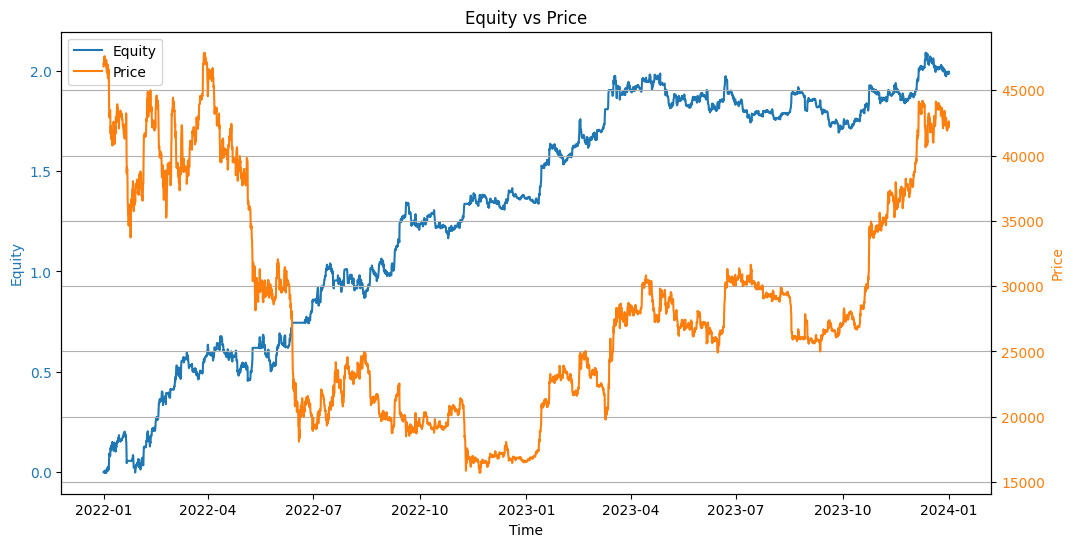

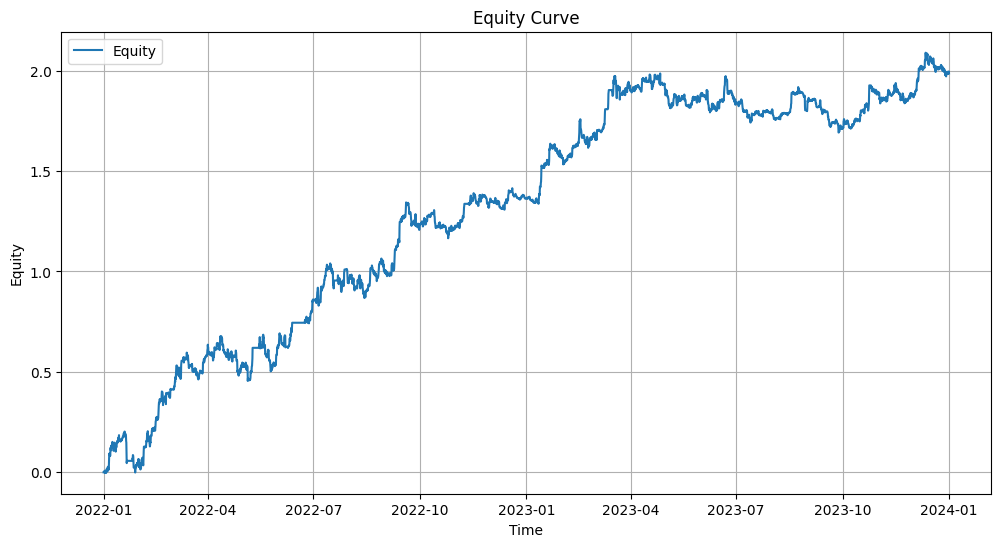

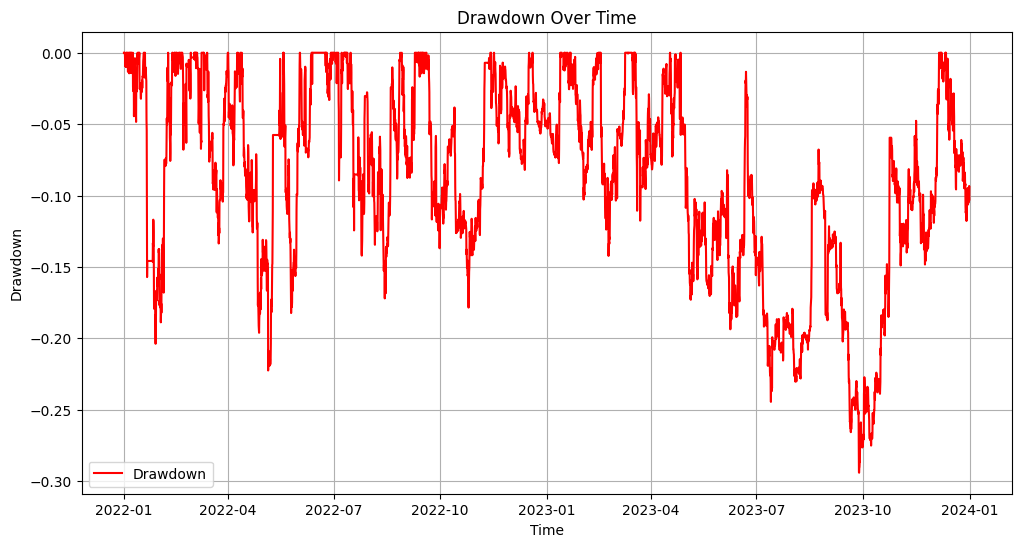

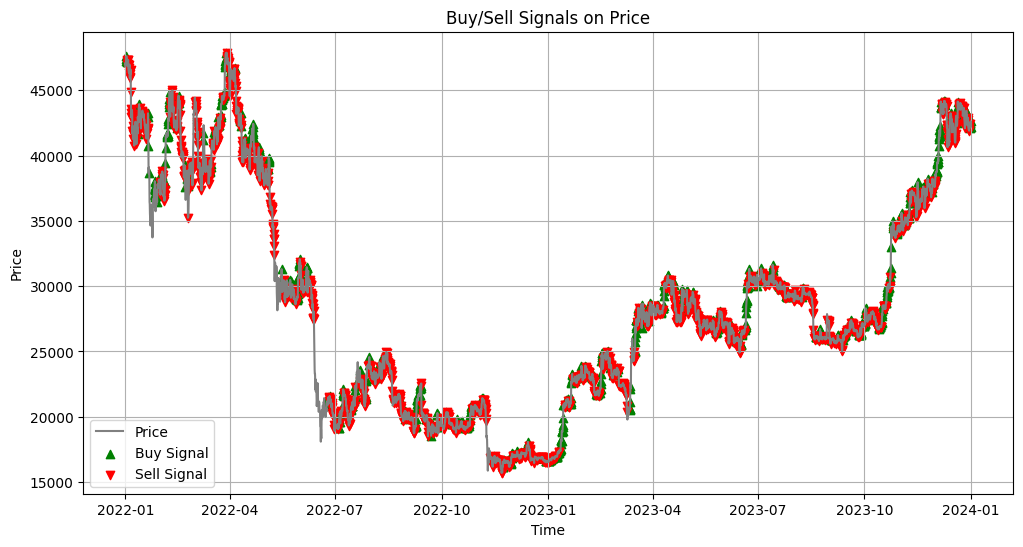


Forward test performance: 
Sharpe Ratio: 2.7846740433107646
Max Drawdown: -0.22287791729111853
Trade Frequency: 0.19543859649122808


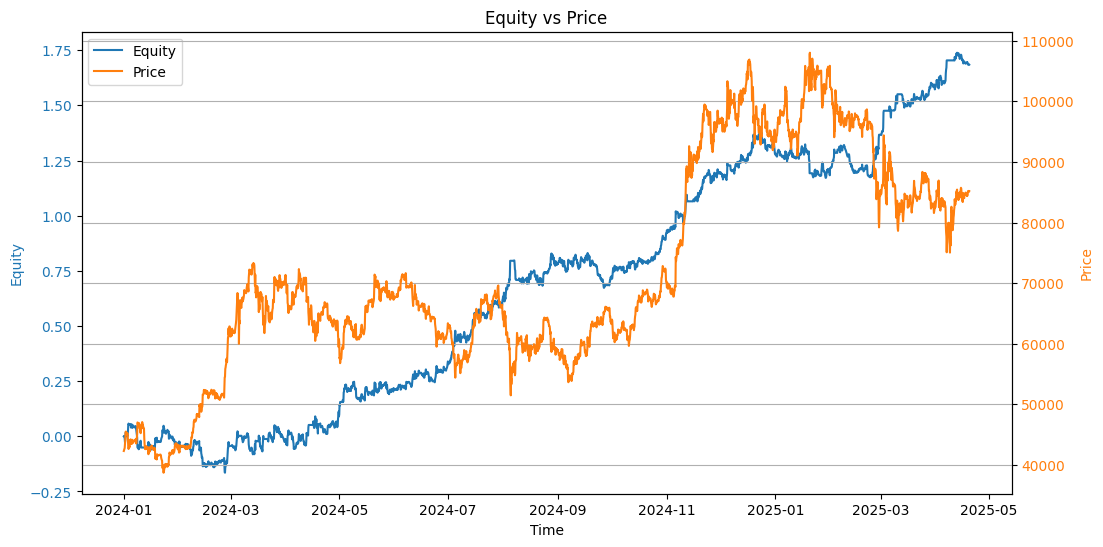

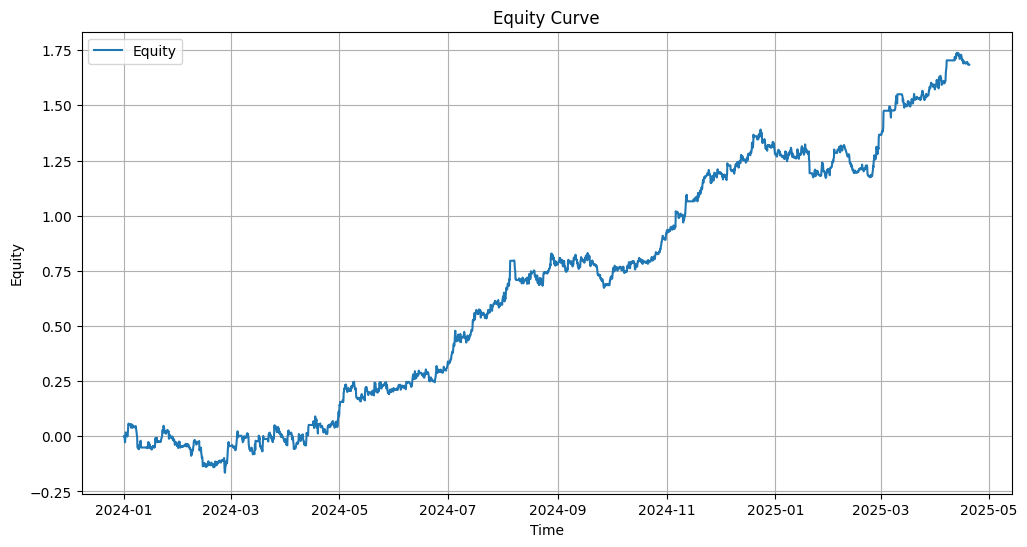

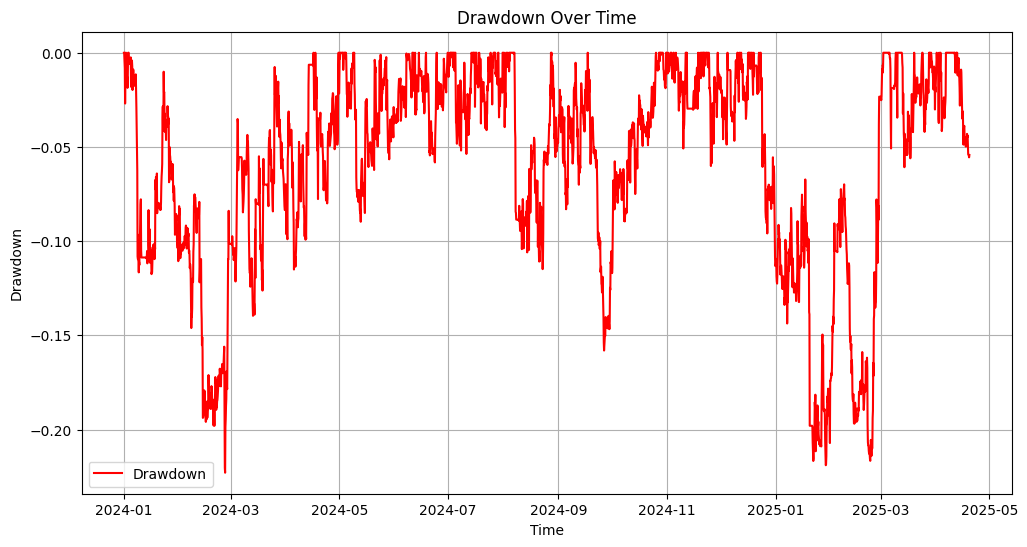

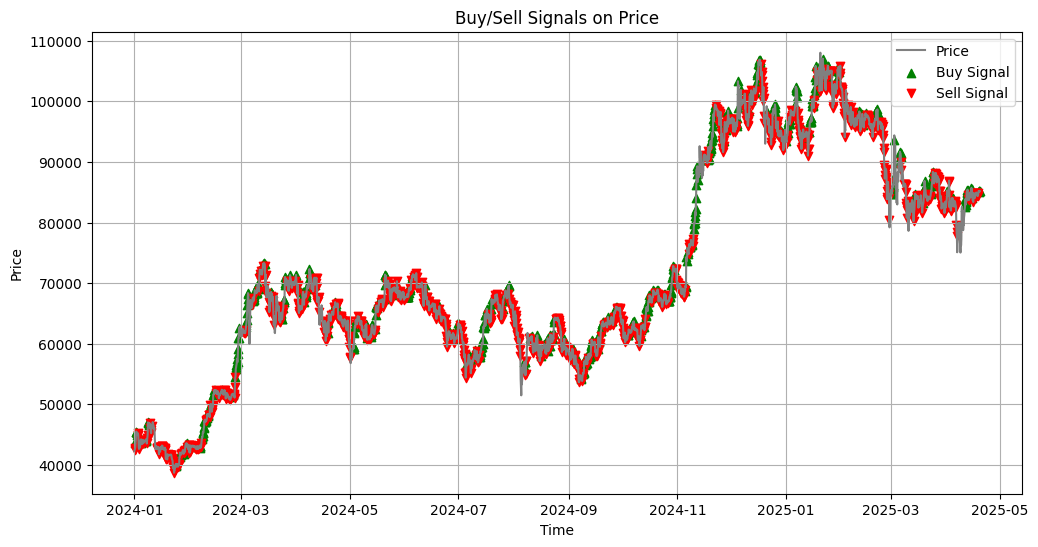

In [112]:
# Initialize  HMMGMMTester
tester = HMMGMMTester(model_path_prefix="/content")

# Backtesting
print("Backtest performance: ")
backtest_results = tester.run_backtest('/content/featured_btest.csv', Backtester)

# Forward testing
print("\nForward test performance: ")
forward_test_results = tester.run_backtest('/content/featured_ftest.csv', Backtester)


# **Reinforcement Learning**

Datasets from HMM-GMM model include regime, intensity and others features are passed to the Deep Reinforcement Learning(DRL) model to find best action (sell, buy or hold) with reward and penalty function.

In [ ]:
# RL Agent class
class RLAgent:
    def __init__(self, state_size, action_size=3):
        self.state_size = state_size
        self.action_size = action_size  # 3 actions: -1 (sell), 0 (hold), 1 (buy)
        self.memory = deque(maxlen=2000)

        self.gamma = 0.95                # Discount factor
        self.epsilon = 1.0               # Exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995

        self.learning_rate = 0.001

        self.model = self._build_model()
        self.target_model = self._build_model()
        self.update_target_model()

    def _build_model(self):
        model = Sequential()
        model.add(Dense(64, input_dim=self.state_size, activation='relu'))
        model.add(Dense(64, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='mse', optimizer=Adam(learning_rate=self.learning_rate))
        return model

    def update_target_model(self):
        """Copy weights from model to target model."""
        self.target_model.set_weights(self.model.get_weights())

    def remember(self, state, action_idx, reward, next_state, done):
        self.memory.append((state, action_idx, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            action_idx = np.random.randint(0, self.action_size)
        else:
            state_array = np.array([state])
            act_values = self.model.predict(state_array, verbose=0)
            action_idx = np.argmax(act_values[0])

        # Convert action index (0,1,2) to signal (-1,0,1)
        action_signal = action_idx - 1
        return action_signal, action_idx

    def replay(self, batch_size):
        if len(self.memory) < batch_size:
            return

        minibatch = random.sample(self.memory, batch_size)
        for state, action_idx, reward, next_state, done in minibatch:
            state_array = np.array([state])
            next_state_array = np.array([next_state])

            target = self.model.predict(state_array, verbose=0)[0]
            if done:
                target[action_idx] = reward
            else:
                next_q_values = self.target_model.predict(next_state_array, verbose=0)[0]
                max_next_q = np.max(next_q_values)
                target[action_idx] = reward + self.gamma * max_next_q

            self.model.fit(state_array, np.array([target]), epochs=1, verbose=0)

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def load(self, name):
        self.model.load_weights(name)
        self.update_target_model()

    def save(self, name):
        self.model.save_weights(name)


class ProgressiveBacktester:
    """
    A wrapper around your Backtester that provides progressive evaluation
    for each decision point in the dataset.
    """
    def __init__(self, backtest_class, data_df, window_size=100):
        self.Backtester = backtest_class
        self.data_df = data_df
        self.window_size = window_size  # Minimum window size to calculate metrics

    def evaluate_decision(self, signals_df, current_idx):
        """Evaluate the performance impact of decisions up to the current index"""
        if current_idx < self.window_size:
            # Not enough data for meaningful evaluation
            return 0, 0, 0

        # Create a subset of data and signals up to current point
        subset_data = self.data_df.iloc[:current_idx+1].copy()
        subset_signals = signals_df[signals_df['timestamp'] <= self.data_df.iloc[current_idx]['timestamp']].copy()

        # Run backtest on this subset
        backtester = self.Backtester(subset_signals, subset_data)
        backtester.run()

        # Get metrics from the backtester attributes
        return backtester.sharpe, backtester.max_drawdown, backtester.trade_frequency


class Trading:
    def __init__(self, market_data, rl_agent, backtest_class):
        self.market_data = market_data.copy()
        self.rl_agent = rl_agent
        self.Backtester = backtest_class
        self.progressive_backtester = ProgressiveBacktester(backtest_class, market_data)

        # Track performance over episodes
        self.episode_performance = []

    def calculate_reward(self, sharpe_ratio, mdd, trade_frequency, immediate_return=0):
        """Calculate reward based on performance metrics and immediate return"""
        # Cap metrics to prevent extreme values
        sharpe_ratio = np.clip(sharpe_ratio, -10, 10)
        mdd = np.clip(mdd, -1, 0)

        # Weights for different components
        w_immediate = 0.3
        w_sharpe = 0.4
        w_mdd = 0.2
        w_trade_freq = 0.1

        # Penalize extreme trade frequencies (want moderate trading)
        ideal_trade_freq = 0.05  # Adjust based on your preference
        freq_penalty = -abs(trade_frequency - ideal_trade_freq) * 2

        # Combined reward
        reward = (w_immediate * immediate_return +
                  w_sharpe * sharpe_ratio +
                  w_mdd * mdd +  # MDD is already negative
                  w_trade_freq * freq_penalty)

        return reward

    def preprocess_state(self, row):
        """Convert a row of data into the state vector"""
        state = np.array([
            row['price'],
            row['regime'],
            row['mvrv'],
            row['sopr'],
            row['fearGreed']
        ])
        return state

    def train_agent(self, epochs=10, batch_size=32, eval_interval=20):
        """Train the RL agent over multiple epochs"""
        for epoch in range(epochs):
            print(f"Epoch {epoch+1}/{epochs}")

            # Run full episode
            metrics = self.run_episode(batch_size, eval_interval)

            # Track performance
            self.episode_performance.append(metrics)

            print(f"Sharpe: {metrics['sharpe']:.4f}, MDD: {metrics['mdd']:.4f}, "
                  f"Trade Freq: {metrics['trade_freq']:.4f}")

            # Update target network periodically
            if epoch % 5 == -0:
                self.rl_agent.update_target_model()

        return self.episode_performance

    def run_episode(self, batch_size=32, eval_interval=20):
        """Run one full episode (training iteration) on the dataset"""
        signals = []
        cumulative_reward = 0

        # Step through the dataset and make trading decisions
        for idx, row in self.market_data.iterrows():
            state = self.preprocess_state(row)

            # Get action: -1 (sell), 0 (hold), 1 (buy)
            signal, action_idx = self.rl_agent.act(state)

            # Record signal
            signals.append({
                'timestamp': row['timestamp'],
                'signal': signal
            })

            # Create signals dataframe up to current point
            current_signals_df = pd.DataFrame(signals)

            # Periodically evaluate performance for efficiency
            if idx % eval_interval == 0 and idx > 0:
                # Get progressive evaluation
                sharpe, mdd, trade_freq = self.progressive_backtester.evaluate_decision(
                    current_signals_df, idx)

                # Calculate immediate reward based on most recent price change
                if idx > 0:
                    previous_price = self.market_data.iloc[idx-1]['price']
                    current_price = row['price']
                    price_change_pct = (current_price - previous_price) / previous_price

                    # Immediate reward based on position and price change
                    previous_signal = signals[-2]['signal'] if len(signals) > 1 else 0
                    immediate_reward = previous_signal * price_change_pct
                else:
                    immediate_reward = 0

                # Calculate combined reward
                reward = self.calculate_reward(sharpe, mdd, trade_freq, immediate_reward)
                cumulative_reward += reward

                # Get next state if available
                if idx < len(self.market_data) - 1:
                    next_state = self.preprocess_state(self.market_data.iloc[idx+1])
                    done = False
                else:
                    next_state = state  # Use current state as next state for terminal state
                    done = True

                # Remember this experience
                self.rl_agent.remember(state, action_idx, reward, next_state, done)

                # Train on batch
                self.rl_agent.replay(batch_size)

        # Run final backtest on the complete dataset
        signals_df = pd.DataFrame(signals)
        backtester = self.Backtester(signals_df, self.market_data)
        backtester.run()

        return {
            'sharpe': backtester.sharpe,
            'mdd': backtester.max_drawdown,
            'trade_freq': backtester.trade_frequency,
            'cumulative_reward': cumulative_reward,
            'signals': signals_df
        }

    def test_agent(self, test_data):
        """Test the trained agent on new data without training"""
        signals = []

        # Step through the test dataset
        for idx, row in test_data.iterrows():
            state = self.preprocess_state(row)
            signal, _ = self.rl_agent.act(state)

            signals.append({
                'timestamp': row['timestamp'],
                'signal': signal
            })

        # Create signals dataframe
        signals_df = pd.DataFrame(signals)

        # Run backtest
        backtester = self.Backtester(signals_df, test_data)
        backtester.run()

        return {
            'sharpe': backtester.sharpe,
            'mdd': backtester.max_drawdown,
            'trade_freq': backtester.trade_frequency,
            'signals': signals_df
        }


def main():
    # Load market data with regime labels
    market_data = pd.read_csv('regimes_output_gmm_4h_open.csv')

    # Convert timestamp to datetime if needed
    if 'timestamp' in market_data.columns and not pd.api.types.is_datetime64_any_dtype(market_data['timestamp']):
        market_data['timestamp'] = pd.to_datetime(market_data['timestamp'], errors='coerce')
        market_data['timestamp'] = market_data['timestamp'].astype('int64') // 10**6

    # Initialize the RL agent
    # State size: [price, regime_label, mvrv, sopr, fearGreed]
    state_size = 5
    action_size = 3  # -1, 0, 1 mapped to 0, 1, 2 internally

    rl_agent = RLAgent(state_size=state_size, action_size=action_size)

    # Split data for training and testing
    train_size = int(len(market_data) * 0.8)
    train_data = market_data.iloc[:train_size]
    test_data = market_data.iloc[train_size:]

    # Train the agent
    training_env = Trading(market_data=train_data,
                          rl_agent=rl_agent,
                          backtest_class=Backtester)  # Use your imported Backtester class

    perf_history = training_env.train_agent(epochs=30, batch_size=2, eval_interval=500)

    # Save the trained model
    rl_agent.save('rl_trading_model_weights.h5')

    # Test on unseen data
    test_env = Trading(market_data=test_data,
                      rl_agent=rl_agent,
                      backtest_class=Backtester)  # Use your imported Backtester class

    test_results = test_env.test_agent(test_data)

    print("\nTest Results:")
    print(f"Sharpe: {test_results['sharpe']:.4f}")
    print(f"Max Drawdown: {test_results['mdd']:.4f}")
    print(f"Trade Frequency: {test_results['trade_freq']:.4f}")

    print("Training and testing completed.")

if __name__ == "__main__":
    main()

# **Alternative way**

This is a hybrid trading strategy that combines sentiment analysis, buzz factor, whale scoring, and market regimes into a single engineered score. This score is used as the primary feature to train a lightweight classifier — XGBoost — to predict short-term price movement direction, and subsequently decide whether to Buy, Sell, or Hold.

The strategy is evaluated using Sharpe Ratio, Cumulative Return, and Max Drawdown. We also track actual trading actions for backtesting purposes.

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [22:51:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


          date       prices  regime regime_label      sopr      mvrv  \
444 2025-02-13  96678.81461       4      bearish  1.015993  2.188586   
445 2025-02-13  95686.20051       4      bearish  0.995878  2.171059   
446 2025-02-13  96044.90335       4      bearish  1.024098  2.177568   
447 2025-02-13  96118.75571       4      bearish  1.018647  2.188743   
448 2025-02-13  97543.40195       4      bearish  1.018148  2.217637   
449 2025-02-13  95980.65417       4      bearish  1.006324  2.180650   
450 2025-02-14  97181.99182       4      bearish  1.013698  2.195090   
451 2025-02-14  97005.49204       4      bearish  1.008289  2.195973   
452 2025-02-14  96940.44302       4      bearish  1.011864  2.199501   
453 2025-02-14  96989.09164       4      bearish  1.034895  2.198009   
454 2025-02-14  98013.40527       4      bearish  1.044002  2.224007   
455 2025-02-14  97553.75529       4      bearish  1.011053  2.206234   
456 2025-02-15  97598.71323       4      bearish  1.020914  2.20

<ipython-input-85-6b3cfdf4313e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strategy.rename(columns={'date': 'timestamp'}, inplace=True)
<ipython-input-85-6b3cfdf4313e>:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strategy.rename(columns={'action': 'signal'}, inplace=True)


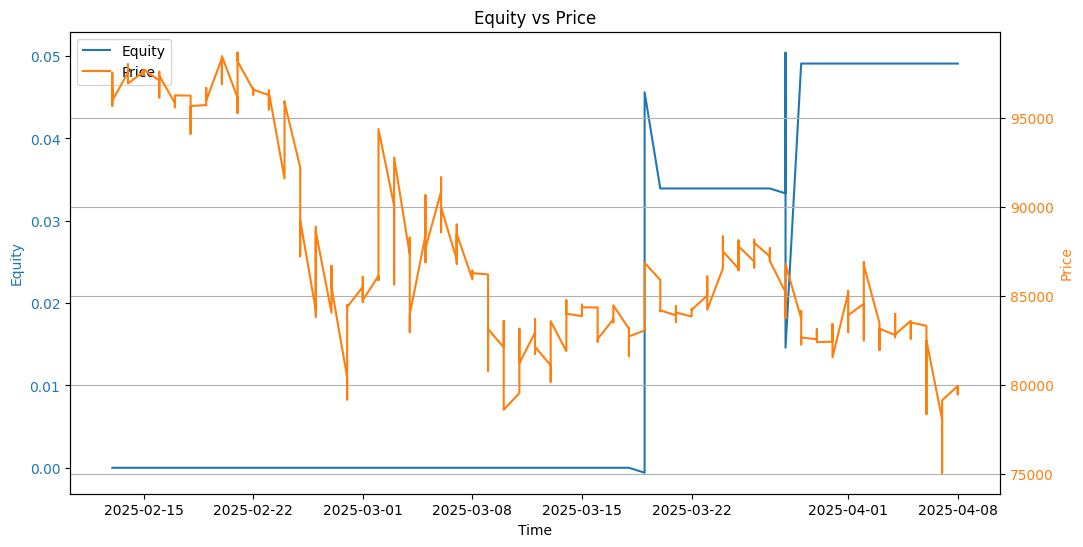

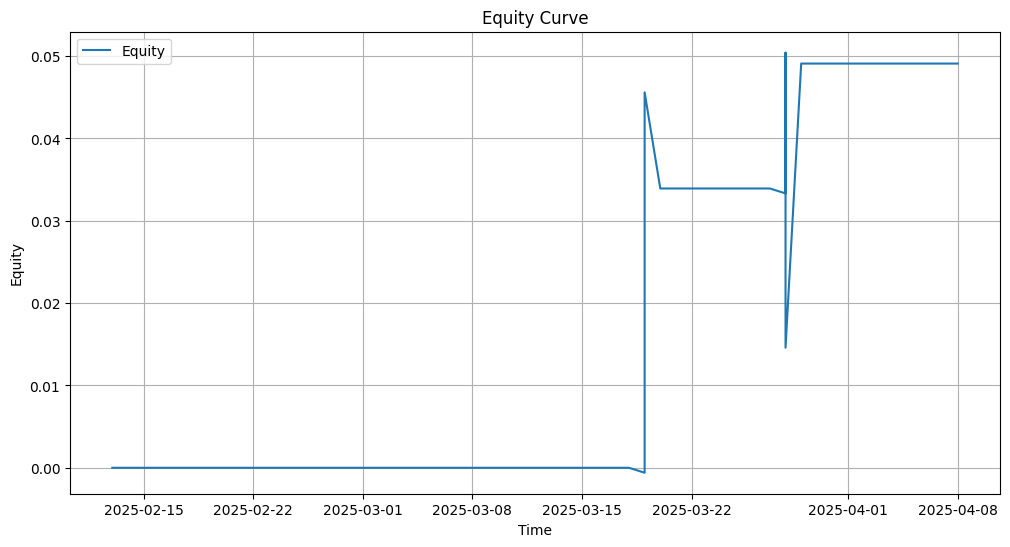

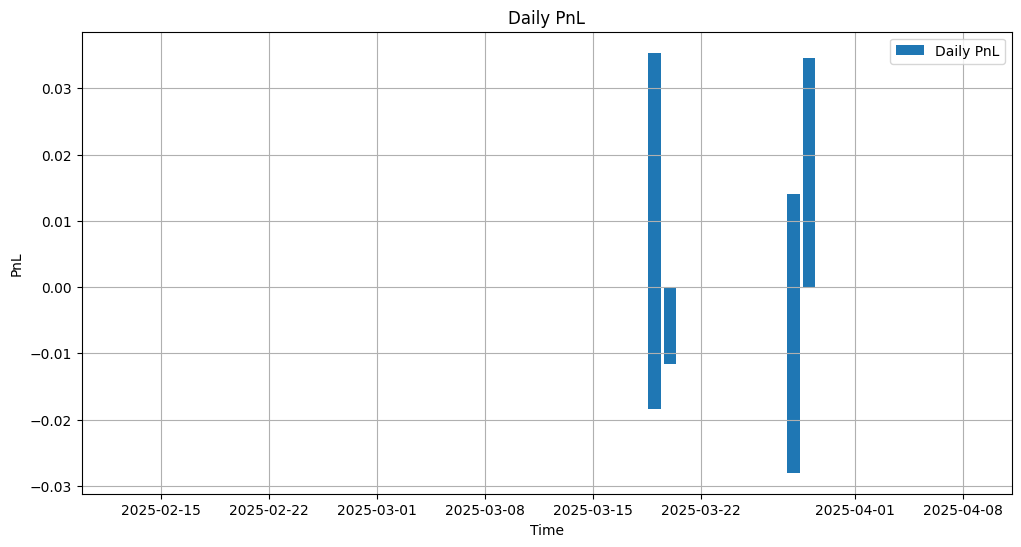

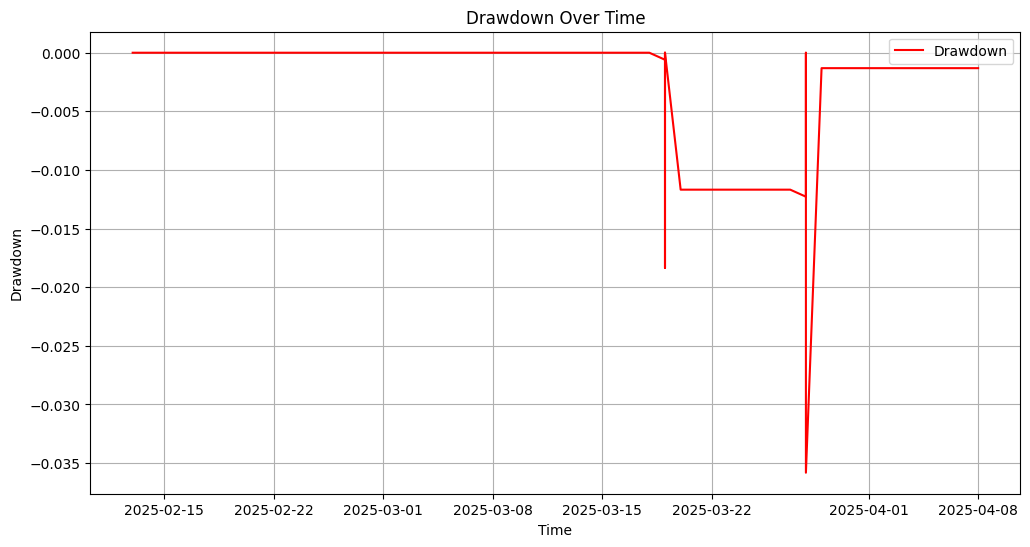

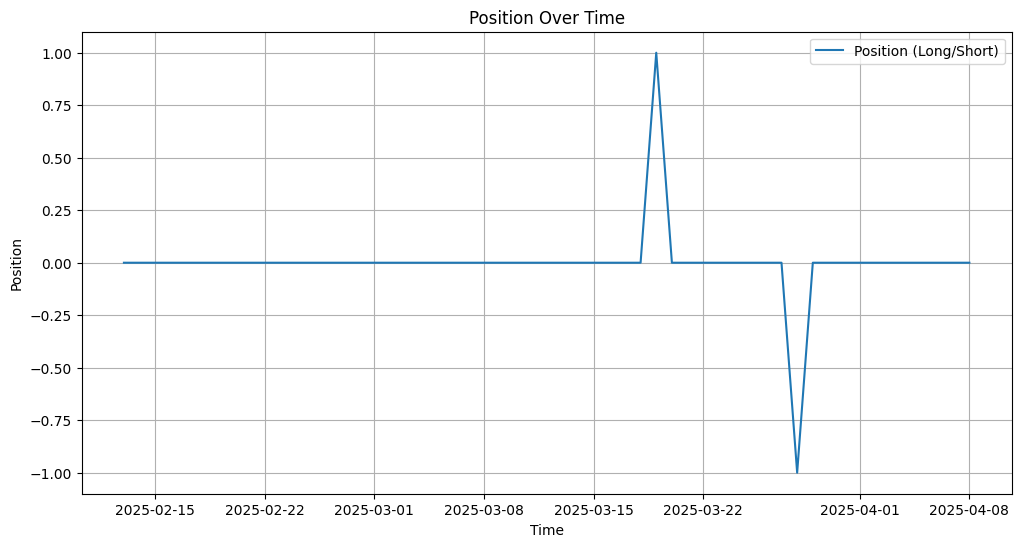

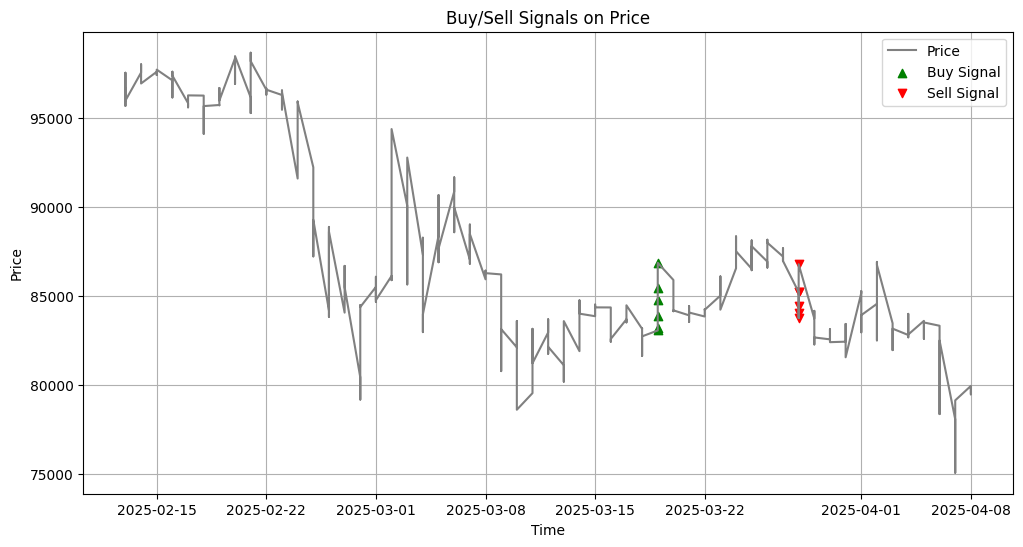

In [85]:
#  Load and Prepare Dataset
# Read the merged dataset that includes market regimes, sentiment scores, and whale data
df = pd.read_csv("merged_regime_features.csv")

# Convert the date column into proper datetime format and filter only valid rows from Dec 2024 onwards
df['date'] = pd.to_datetime(df['date'], errors='coerce', dayfirst=True)
df = df.dropna(subset=['date'])
df = df[df['date'] >= pd.to_datetime("2024-12-01")]
df = df.sort_values('date').reset_index(drop=True)


# Calculate the price change to determine if the price will go up (1) or down (0) — this becomes our target label
df['next_price'] = df['prices'].shift(-1)
df['price_change'] = df['next_price'] - df['prices']
df['target'] = (df['price_change'] > 0).astype(int)
df = df.dropna(subset=['next_price'])

#  Train-Test Split Based on Time
# Use the first 4/7 of the data as training and the remaining 3/7 as testing
start_date = df['date'].min()
end_date = df['date'].max()
total_duration = (end_date - start_date).days
train_duration = total_duration * 4 / 7
train_end_date = start_date + pd.Timedelta(days=train_duration)

df_train = df[df['date'] < train_end_date]
df_test = df[df['date'] >= train_end_date]

#  Assign Feature Weights
# Adjust these based on your experiment or grid search
coindesk_weight = 0.4
reddit_weight = 0.6
whale_weight = 0.4

def weighted_score(row, w_coindesk, w_reddit):
    coindesk = row['combined_zscore_coindesk']
    reddit = row['combined_zscore_reddit']
    if pd.notna(coindesk) and pd.notna(reddit):
        return w_coindesk * coindesk + w_reddit * reddit
    elif pd.notna(coindesk):
        return coindesk
    elif pd.notna(reddit):
        return reddit
    return None

#  Feature Engineering
# Generate a combined sentiment score, then compute the final score by integrating whale activity and regime info
df['combined_score'] = df.apply(weighted_score, axis=1, args=(coindesk_weight, reddit_weight))
df = df.dropna(subset=['combined_score'])

# Final feature for prediction = sentiment + whale behavior + market regime
df['final_score'] = df['combined_score'] + whale_weight * df['whale_score']

# Re-split after final_score processing to avoid NaN issues
df_train = df[df['date'] < train_end_date]
df_test = df[df['date'] >= train_end_date]

#  Train Classifier
# Use XGBoost for binary classification (predict up/down trend)
X_train = df_train[['final_score']]
y_train = df_train['target']
X_test = df_test[['final_score']]
y_test = df_test['target']

model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', objective='binary:logistic', random_state=42)
model.fit(X_train, y_train)
preds = model.predict(X_test)


# Strategy Simulation
# Simulate trading actions based on model prediction
df_test = df_test.copy()
df_test['prediction'] = preds
df_test['return'] = (df_test['next_price'] - df_test['prices']) / df_test['prices']
df_test['position'] = df_test['prediction']  # 1 = Buy/Hold, 0 = Do nothing
df_test['prev_position'] = df_test['position'].shift(1).fillna(0)
df_test['trade'] = (df_test['position'] > df_test['prev_position']).astype(int)

#  Signal Mapping

def classify_action(row):
    if row['prev_position'] == 0 and row['position'] == 1:
        return 1
    elif row['prev_position'] == 1 and row['position'] == 0:
        return -1
    elif row['position'] == row['prev_position'] == 1:
        return 0
    return 0

df_test['action'] = df_test.apply(classify_action, axis=1)
print(df_test.head(20))


# rename the strategy and test to fit the backtester
df_strategy = df_test[['date','action']]
df_strategy.rename(columns={'date': 'timestamp'}, inplace=True)
df_strategy.rename(columns={'action': 'signal'}, inplace=True)
df_test.rename(columns={'date': 'timestamp'}, inplace=True)
df_test.rename(columns={'prices': 'price'}, inplace=True)

# call backtest
backtester = Backtester(df_strategy, df_test)
backtester.run()
backtester.plot_equity_vs_close()
backtester.plot_equity_curve()
backtester.plot_daily_pnl()
backtester.plot_drawdown()
backtester.plot_positions()
backtester.plot_signals_on_price()
